Processing 0004_000...
Image 0 shape: (1024, 1024, 3)
Image 1 shape: (1024, 1024, 3)
Mask 0 shape: (1024, 1024), unique values: [  0 255]
Mask 1 shape: (1024, 1024), unique values: [  0 255]
Intrinsic 0:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]
Intrinsic 1:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]

Baseline distance: 0.788222 units

Rectifying stereo pair (Central Axis)...
Rectification matrices computed
New projection matrix P0:
[[819.2   0.  512.    0. ]
 [  0.  819.2 537.    0. ]
 [  0.    0.    1.    0. ]]
New projection matrix P1:
[[ 819.2           0.          512.         -645.71162867]
 [   0.          819.2         537.            0.        ]
 [   0.            0.            1.            0.        ]]


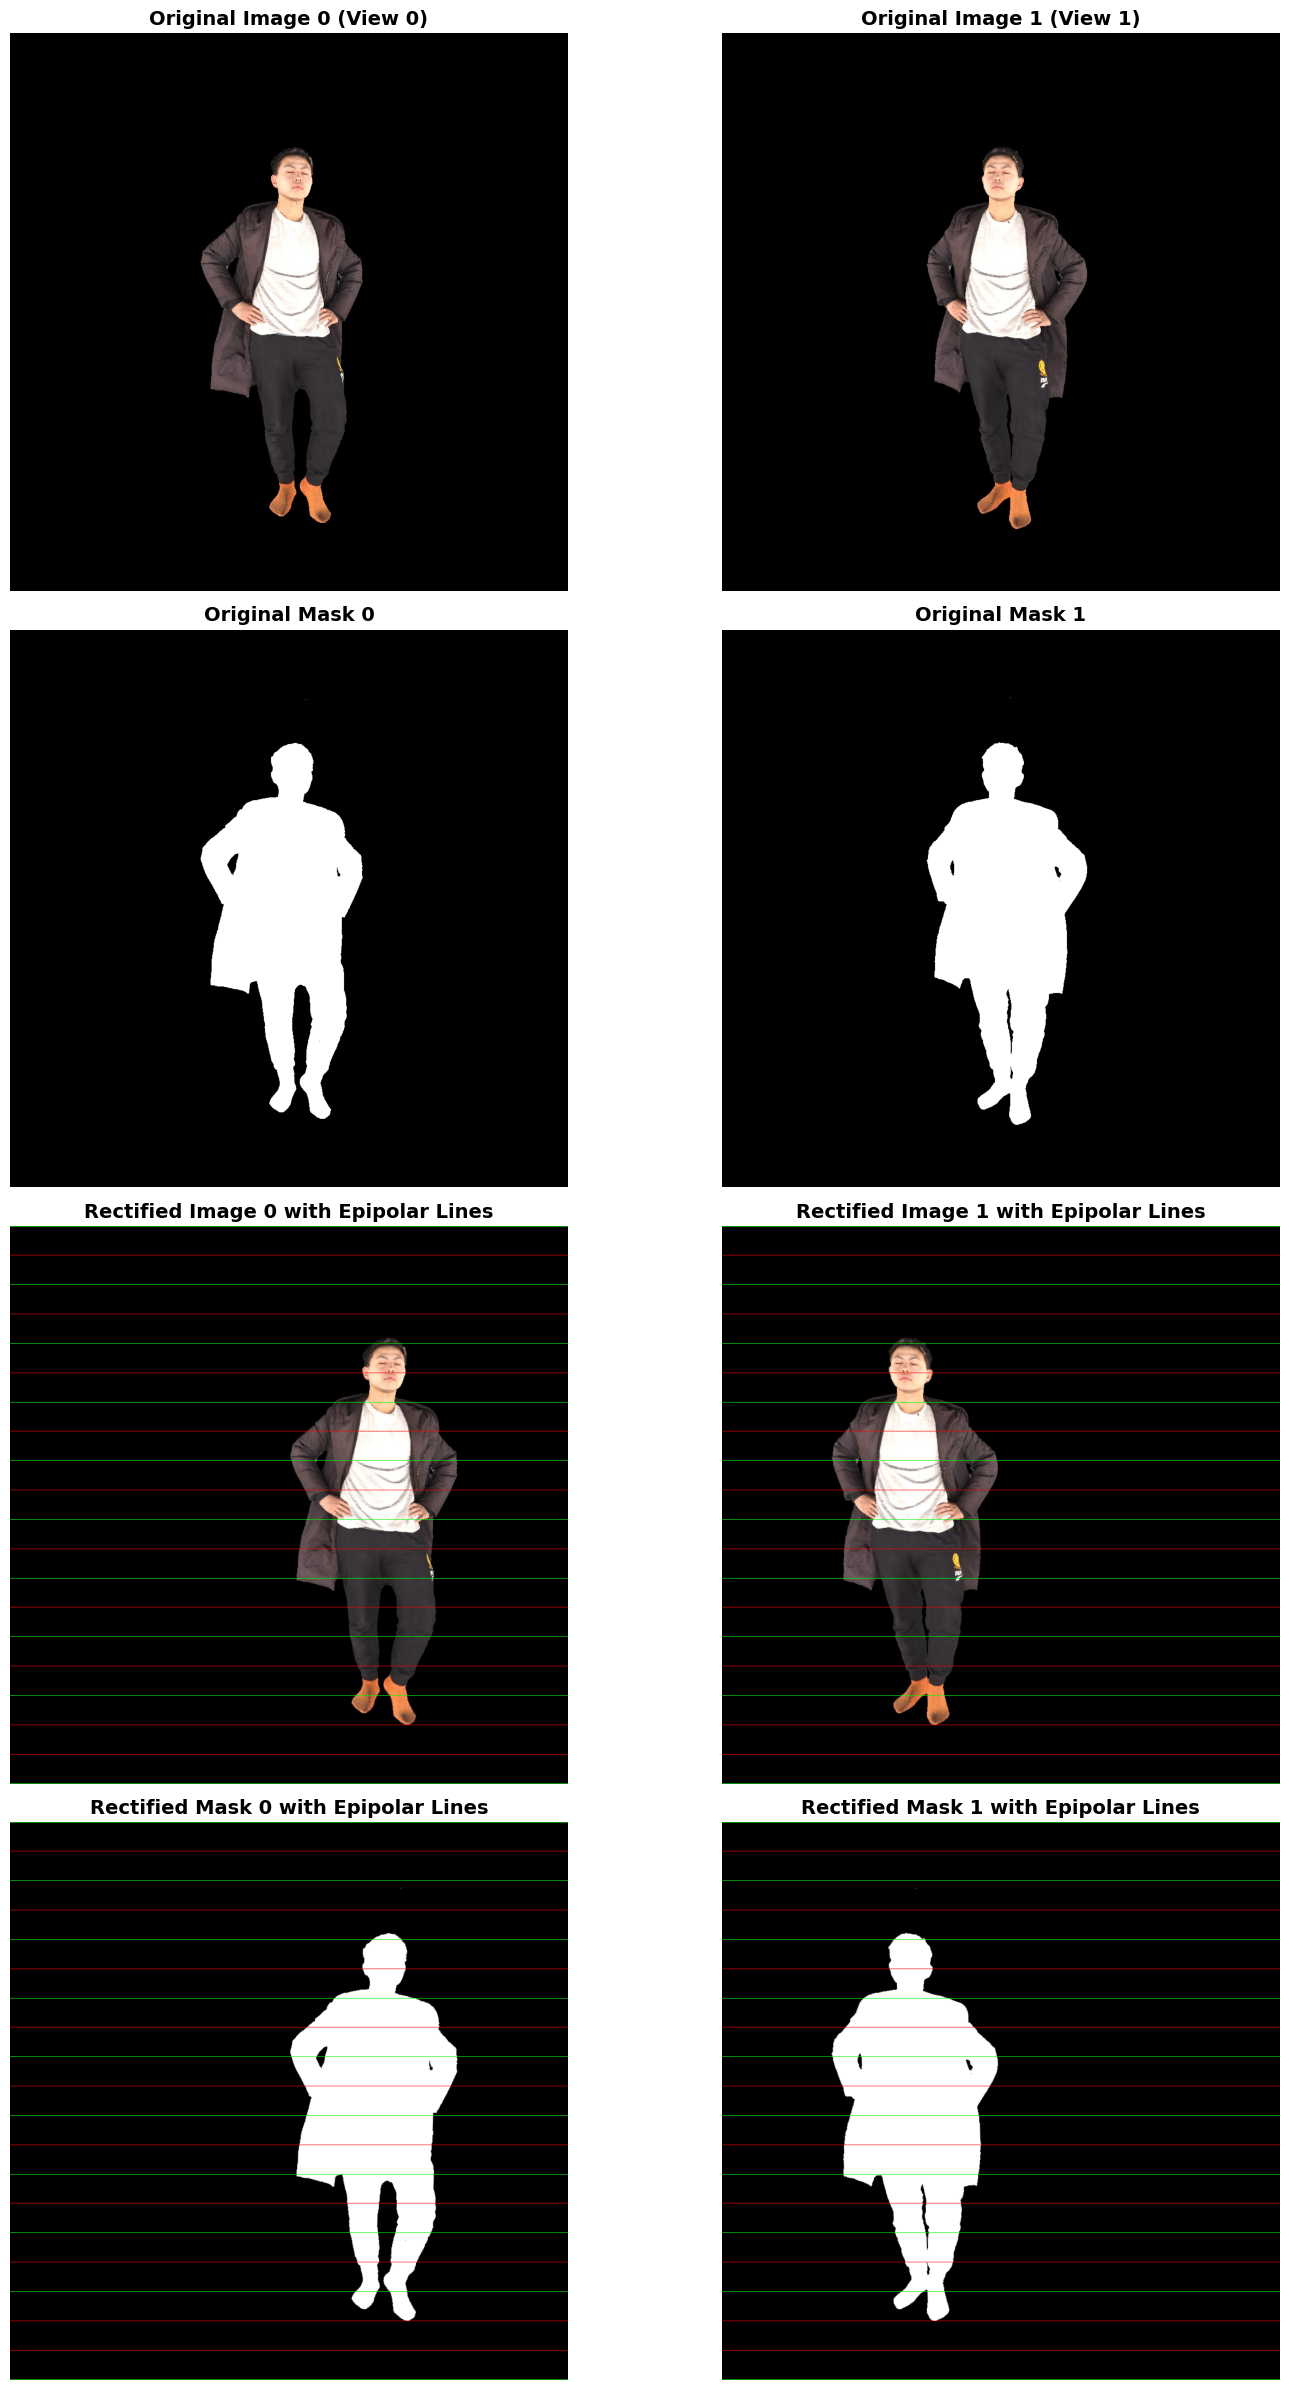

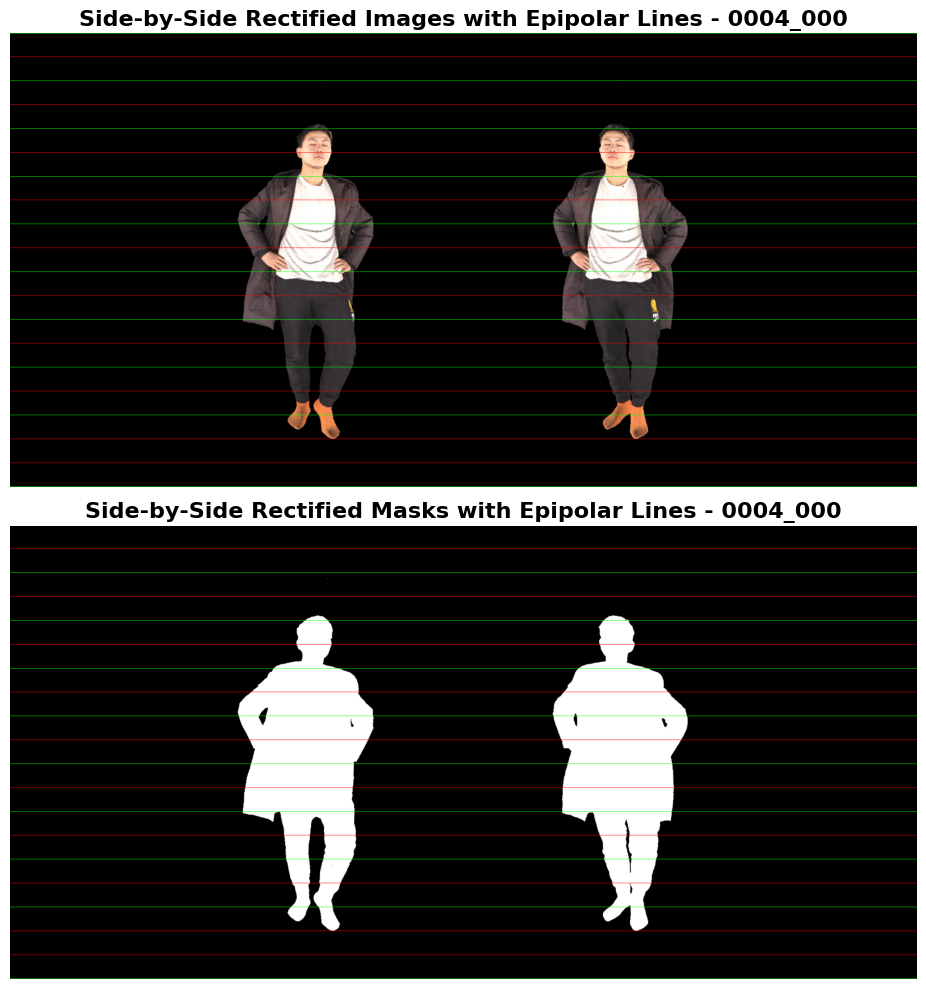


✓ Rectification complete (Central Axis Method)!

How to verify rectification quality:
1. Corresponding points in both images should lie on the same horizontal line
2. The colored horizontal lines should align perfectly across both images
3. Any vertical disparity indicates poor rectification
4. Mask boundaries should also align on the same horizontal lines


In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy.spatial.transform import Slerp
from scipy.spatial.transform import Rotation as R_

def load_camera_params(data_root, view_name, view_id):
    """Load camera parameters for a specific view"""
    intr_path = os.path.join(data_root, 'parm', view_name, f'{view_id}_intrinsic.npy')
    extr_path = os.path.join(data_root, 'parm', view_name, f'{view_id}_extrinsic.npy')
    
    intrinsic = np.load(intr_path)
    extrinsic = np.load(extr_path)
    
    return intrinsic, extrinsic

def load_image_and_mask(data_root, view_name, view_id):
    """Load image and mask for a specific view"""
    img_path = os.path.join(data_root, 'img', view_name, f'{view_id}.jpg')
    mask_path = os.path.join(data_root, 'mask', view_name, f'{view_id}.png')
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if len(mask.shape) > 2:
        mask = mask[:, :, 0]
    
    return img, mask

def draw_epipolar_lines(img0, img1, num_lines=20):
    """
    Draw horizontal epipolar lines on both images for verification
    """
    H, W = img0.shape[:2]
    
    # Create copies to draw on
    img0_lines = img0.copy()
    img1_lines = img1.copy()
    
    # Draw horizontal lines at regular intervals
    line_positions = np.linspace(0, H-1, num_lines, dtype=int)
    
    for y in line_positions:
        # Alternate colors for better visibility
        color = (0, 255, 0) if (y // (H // num_lines)) % 2 == 0 else (255, 0, 0)
        cv2.line(img0_lines, (0, y), (W-1, y), color, 1)
        cv2.line(img1_lines, (0, y), (W-1, y), color, 1)
    
    return img0_lines, img1_lines

def stereo_rectify_central_axis(cams_info, world_cam_extrs, cam_ids):
    """
    Rectify two cameras to a common 'central' axis.

    INPUTS
      cams_info: list of dicts with 'K','width','height'
      world_cam_extrs: list of 4x4 world->camera extrinsics (E = [R|t] with x_cam = R x_world + t)
      cam_ids: pair [i,j]

    RETURNS (same contract as your code expects)
      R1_rect, R2_rect, P1_rect, P2_rect, Q
      where exterior code will do `new_extr = R_rect @ old_extr` (3x3 @ 3x4).
    """
    E1 = world_cam_extrs[cam_ids[0]]
    E2 = world_cam_extrs[cam_ids[1]]

    K1 = np.array(cams_info[cam_ids[0]]["K"], dtype=np.float64)
    K2 = np.array(cams_info[cam_ids[1]]["K"], dtype=np.float64)

    # world->camera rotations and translations
    R1_wc = E1[:3, :3].astype(np.float64)
    t1_wc = E1[:3, 3].astype(np.float64)
    R2_wc = E2[:3, :3].astype(np.float64)
    t2_wc = E2[:3, 3].astype(np.float64)

    # camera -> world rotations (useful to get camera axes in WORLD frame)
    C1 = R1_wc.T
    C2 = R2_wc.T

    # camera centers in world coordinates: c = -R.T @ t
    c1_world = -C1 @ t1_wc
    c2_world = -C2 @ t2_wc

    # baseline vector in WORLD coordinates
    baseline_world = c2_world - c1_world
    bl_norm = np.linalg.norm(baseline_world)

    x_axis = baseline_world / bl_norm  # desired rectified x axis (points from cam1->cam2)

    # average camera_to_world orientation (slerp between camera->world rotations)
    slerp = Slerp([0, 1], R_.from_matrix([C1, C2]))
    C_central = slerp(0.5).as_matrix()

    # optical axis (forward) in WORLD coords. For our frustum convention optical = -Z in camera coords.
    z_guess_world = C_central[:, 2]

    # orthogonalize the forward guess to the baseline (so x and z are orthogonal)
    z_axis = z_guess_world - np.dot(z_guess_world, x_axis) * x_axis
    z_norm = np.linalg.norm(z_axis)
    if z_norm < 1e-9:
        # fallback: pick any vector orthogonal to x_axis
        if abs(x_axis[0]) < abs(x_axis[1]):
            tmp = np.array([1.0, 0.0, 0.0])
        else:
            tmp = np.array([0.0, 1.0, 0.0])
        z_axis = tmp - np.dot(tmp, x_axis) * x_axis
        z_axis /= np.linalg.norm(z_axis)
    else:
        z_axis /= z_norm

    # complete right-handed frame: y = z x x (so x, y, z form RHS with x cross y = z)
    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.linalg.norm(y_axis)

    # Basis matrix B: columns are rectified axes expressed in WORLD coords:
    # B maps rectified-frame vectors -> world vectors
    B = np.column_stack([x_axis, y_axis, z_axis])  # 3x3

    # R_world_to_rect = B.T maps world vectors -> rectified-frame vectors
    R_world_to_rect = B.T

    # IMPORTANT: the R returned to outside must satisfy
    #   new_extr = R_rect @ old_extr
    # and so new_extr[:3,:3] = (R_rect @ R_wc) must equal R_world_to_rect.
    # From algebra R_rect must be R_world_to_rect @ R_wc.T
    R1_rect = R_world_to_rect @ R1_wc.T  # maps camera1 coords -> rectified coords
    R2_rect = R_world_to_rect @ R2_wc.T  # maps camera2 coords -> rectified coords

    # Projection matrices (use averaged intrinsics)
    f = 0.5 * (K1[0, 0] + K2[0, 0])
    cx = 0.5 * (K1[0, 2] + K2[0, 2])
    cy = 0.5 * (K1[1, 2] + K2[1, 2])

    # baseline expressed in rectified frame
    baseline_rect = R_world_to_rect @ baseline_world
    bx = baseline_rect[0]

    # Standard symmetric P1,P2: left uses [I|0], right has x-shift = -f * baseline_x
    P1_rect = np.array([[f, 0, cx, 0.0], [0, f, cy, 0.0], [0, 0, 1, 0.0]], dtype=np.float64)

    # pixel translation for P2: negative because if cam2 is +x in rect frame we want P2 to have -f*baseline
    P2_rect = np.array([[f, 0, cx, -f * bx], [0, f, cy, 0.0], [0, 0, 1, 0.0]], dtype=np.float64)

    # Build a Q similar to cv2.stereoRectify (for symmetric intrinsics, cx==cx')
    # Tx for Q formula is P2[0,3]/f = -bx
    Tx = P2_rect[0, 3] / f  # equals -bx
    # Use the usual pattern: Q[3,2] = -1/Tx (cv uses -1/Tx)
    # Because Tx is P2[0,3]/f, when P2[0,3] = -f*bx -> Tx = -bx -> -1/Tx = 1/bx
    Q = np.array(
        [[1.0, 0.0, 0.0, -cx], [0.0, 1.0, 0.0, -cy], [0.0, 0.0, 0.0, f], [0.0, 0.0, -1.0 / Tx, 0.0]], dtype=np.float64
    )

    return R1_rect, R2_rect, P1_rect, P2_rect, Q

# Set paths
data_root = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train'
view_name = '0004_000'

print(f"Processing {view_name}...")

# Load data for view 0 and view 1
img0, mask0 = load_image_and_mask(data_root, view_name, 0)
intr0, extr0 = load_camera_params(data_root, view_name, 0)

img1, mask1 = load_image_and_mask(data_root, view_name, 1)
intr1, extr1 = load_camera_params(data_root, view_name, 1)

print(f"Image 0 shape: {img0.shape}")
print(f"Image 1 shape: {img1.shape}")
print(f"Mask 0 shape: {mask0.shape}, unique values: {np.unique(mask0)}")
print(f"Mask 1 shape: {mask1.shape}, unique values: {np.unique(mask1)}")
print(f"Intrinsic 0:\n{intr0}")
print(f"Intrinsic 1:\n{intr1}")

# Compute camera separation
r0, t0 = extr0[:3, :3], extr0[:3, 3]
r1, t1 = extr1[:3, :3], extr1[:3, 3]
C0 = -r0.T @ t0
C1 = -r1.T @ t1
baseline = np.linalg.norm(C1 - C0)
print(f"\nBaseline distance: {baseline:.6f} units")

# Rectify stereo pair using stereo_rectify_central_axis
print("\nRectifying stereo pair (Central Axis)...")

H, W = img0.shape[:2]
cams_info = [
    {'K': intr0, 'width': W, 'height': H},
    {'K': intr1, 'width': W, 'height': H}
]
world_cam_extrs = [extr0, extr1]
# Assume view 0 and view 1
cam_ids = [0, 1]

R0_rect, R1_rect, P0_rect, P1_rect, Q = stereo_rectify_central_axis(
    cams_info, world_cam_extrs, cam_ids
)

# Apply rectification
dist0 = np.zeros(4)
dist1 = np.zeros(4)

# Compute maps using R_rect and P_rect
map0_x, map0_y = cv2.initUndistortRectifyMap(intr0, dist0, R0_rect, P0_rect, (W, H), cv2.CV_32FC1)
map1_x, map1_y = cv2.initUndistortRectifyMap(intr1, dist1, R1_rect, P1_rect, (W, H), cv2.CV_32FC1)

rect_img0 = cv2.remap(img0, map0_x, map0_y, cv2.INTER_LINEAR)
rect_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
rect_mask0 = cv2.remap(mask0, map0_x, map0_y, cv2.INTER_LINEAR)
rect_mask1 = cv2.remap(mask1, map1_x, map1_y, cv2.INTER_LINEAR)

print(f"Rectification matrices computed")
print(f"New projection matrix P0:\n{P0_rect}")
print(f"New projection matrix P1:\n{P1_rect}")

# Draw epipolar lines on images
img0_with_lines, img1_with_lines = draw_epipolar_lines(rect_img0, rect_img1, num_lines=20)

# Create visualization
fig, axes = plt.subplots(4, 2, figsize=(16, 24))

# Row 0: Original images
axes[0, 0].imshow(img0)
axes[0, 0].set_title('Original Image 0 (View 0)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img1)
axes[0, 1].set_title('Original Image 1 (View 1)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Row 1: Original masks
axes[1, 0].imshow(mask0, cmap='gray')
axes[1, 0].set_title('Original Mask 0', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask1, cmap='gray')
axes[1, 1].set_title('Original Mask 1', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# Row 2: Rectified images with epipolar lines
axes[2, 0].imshow(img0_with_lines)
axes[2, 0].set_title('Rectified Image 0 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[2, 0].axis('off')

axes[2, 1].imshow(img1_with_lines)
axes[2, 1].set_title('Rectified Image 1 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[2, 1].axis('off')

# Row 3: Rectified masks with epipolar lines
mask0_rgb = cv2.cvtColor(rect_mask0, cv2.COLOR_GRAY2RGB)
mask1_rgb = cv2.cvtColor(rect_mask1, cv2.COLOR_GRAY2RGB)
mask0_with_lines, mask1_with_lines = draw_epipolar_lines(mask0_rgb, mask1_rgb, num_lines=20)

axes[3, 0].imshow(mask0_with_lines)
axes[3, 0].set_title('Rectified Mask 0 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[3, 0].axis('off')

axes[3, 1].imshow(mask1_with_lines)
axes[3, 1].set_title('Rectified Mask 1 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

# Create side-by-side comparisons
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Side-by-side rectified images
combined_img = np.hstack([img0_with_lines, img1_with_lines])
axes[0].imshow(combined_img)
axes[0].set_title(f'Side-by-Side Rectified Images with Epipolar Lines - {view_name}', 
                  fontsize=16, fontweight='bold')
axes[0].axis('off')

# Side-by-side rectified masks
combined_mask = np.hstack([mask0_with_lines, mask1_with_lines])
axes[1].imshow(combined_mask)
axes[1].set_title(f'Side-by-Side Rectified Masks with Epipolar Lines - {view_name}', 
                  fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Rectification complete (Central Axis Method)!")
print("\nHow to verify rectification quality:")
print("1. Corresponding points in both images should lie on the same horizontal line")
print("2. The colored horizontal lines should align perfectly across both images")
print("3. Any vertical disparity indicates poor rectification")
print("4. Mask boundaries should also align on the same horizontal lines")

=== Mask Analysis ===
Mask shape: (1024, 1024), dtype: uint8
Mask unique values: [  0 255]
Mask range: [0, 255]
Number of masked pixels (>128): 110499
Percentage masked: 10.54%

=== Inverse Depth Analysis (all pixels) ===
Inv depth shape: (1024, 1024), dtype: float32
Inv depth range: [0.000000, 0.551880]
Non-zero inv depth pixels: 110499

=== Inverse Depth Analysis (masked pixels only) ===
Masked inv depth range: [0.443726, 0.551880]
Masked inv depth mean: 0.507833
Masked inv depth median: 0.510193

=== Actual Depth (masked, filtered) ===
Depth range: [1.812, 2.254] meters
Depth mean: 1.972 meters
Depth median: 1.960 meters

Drawing cross section line at y = 553


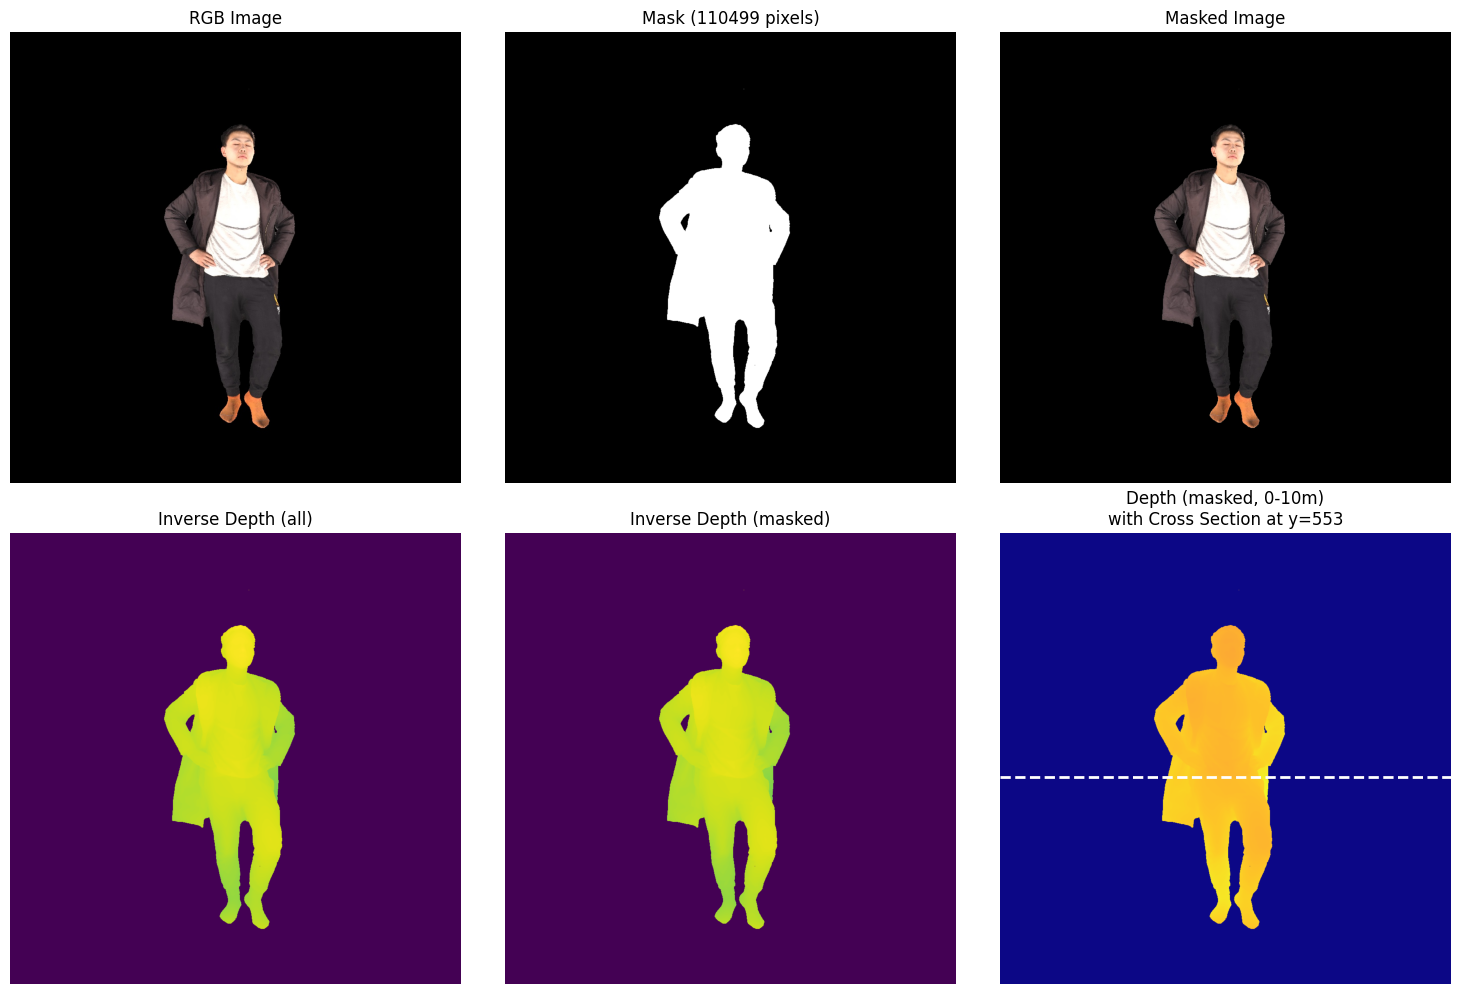

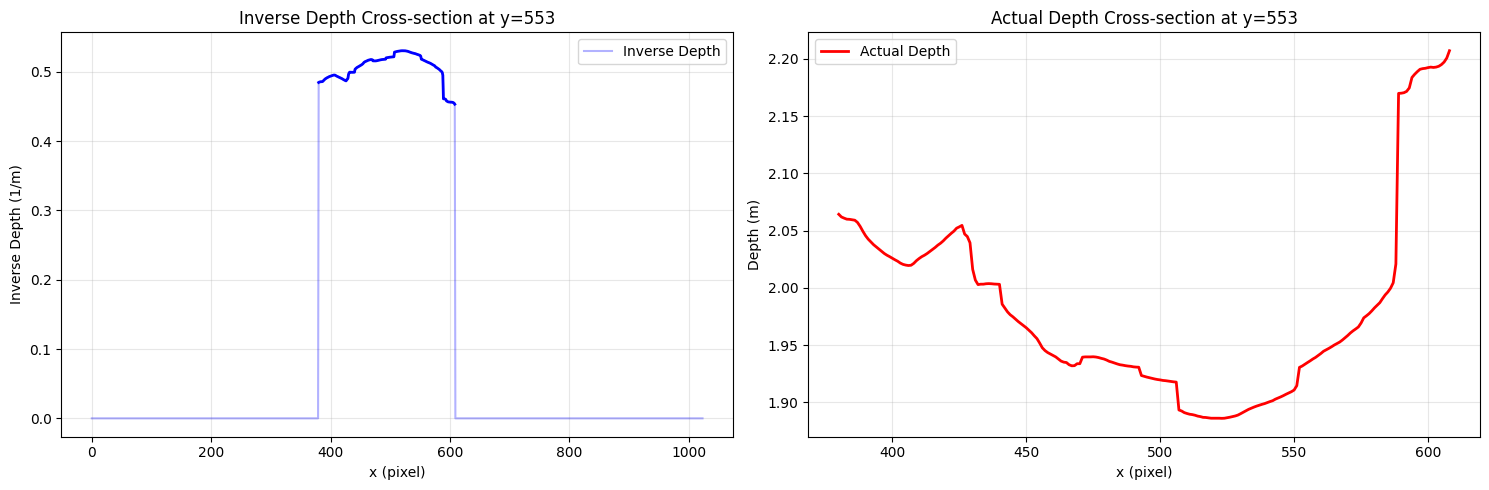

In [74]:
# Let's first visualize the mask, depth, and image together to understand the data
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Set base path
base_path = os.path.join('render_data', 'render_data', 'train', 'parm')
if not os.path.exists(base_path):
    base_path = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train\parm'

train_root = os.path.dirname(base_path)
view_name = '0004_000'

img_path = os.path.join(train_root, 'img', view_name, '0.jpg')
mask_path = os.path.join(train_root, 'mask', view_name, '0.png')
depth_path = os.path.join(train_root, 'depth', view_name, '0.png')

# Load data
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
if len(mask.shape) > 2:
    mask = mask[:, :, 0]

depth_raw = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
inv_depth = depth_raw / (2.0 ** 15)

# Analyze mask
print("=== Mask Analysis ===")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Mask unique values: {np.unique(mask)}")
print(f"Mask range: [{mask.min()}, {mask.max()}]")
print(f"Number of masked pixels (>128): {np.sum(mask > 128)}")
print(f"Percentage masked: {100 * np.sum(mask > 128) / mask.size:.2f}%")

# Analyze inverse depth
print(f"\n=== Inverse Depth Analysis (all pixels) ===")
print(f"Inv depth shape: {inv_depth.shape}, dtype: {inv_depth.dtype}")
print(f"Inv depth range: [{inv_depth.min():.6f}, {inv_depth.max():.6f}]")
print(f"Non-zero inv depth pixels: {np.sum(inv_depth > 0)}")

# Analyze inverse depth within mask
masked_inv_depth = inv_depth[mask > 128]
print(f"\n=== Inverse Depth Analysis (masked pixels only) ===")
print(f"Masked inv depth range: [{masked_inv_depth.min():.6f}, {masked_inv_depth.max():.6f}]")
print(f"Masked inv depth mean: {masked_inv_depth.mean():.6f}")
print(f"Masked inv depth median: {np.median(masked_inv_depth):.6f}")

# Convert to actual depth for masked pixels
masked_depth = 1.0 / (masked_inv_depth + 1e-8)
masked_depth = masked_depth[masked_depth < 100]  # Filter out extreme values
print(f"\n=== Actual Depth (masked, filtered) ===")
print(f"Depth range: [{masked_depth.min():.3f}, {masked_depth.max():.3f}] meters")
print(f"Depth mean: {masked_depth.mean():.3f} meters")
print(f"Depth median: {np.median(masked_depth):.3f} meters")

# Find center y for cross section
y_indices, x_indices = np.where(mask > 128)
if len(y_indices) > 0:
    unique_ys = np.unique(y_indices)
    mid_y = unique_ys[len(unique_ys) // 2]
else:
    mid_y = img.shape[0] // 2
print(f"\nDrawing cross section line at y = {mid_y}")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img)
axes[0, 0].set_title('RGB Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask, cmap='gray')
axes[0, 1].set_title(f'Mask ({np.sum(mask > 128)} pixels)')
axes[0, 1].axis('off')

axes[0, 2].imshow(img * (mask[:, :, np.newaxis] > 128))
axes[0, 2].set_title('Masked Image')
axes[0, 2].axis('off')

axes[1, 0].imshow(inv_depth, cmap='viridis')
axes[1, 0].set_title('Inverse Depth (all)')
axes[1, 0].axis('off')

masked_inv_depth_vis = np.zeros_like(inv_depth)
masked_inv_depth_vis[mask > 128] = inv_depth[mask > 128]
axes[1, 1].imshow(masked_inv_depth_vis, cmap='viridis')
axes[1, 1].set_title('Inverse Depth (masked)')
axes[1, 1].axis('off')

# Depth visualization (clipped for visibility)
depth_vis = 1.0 / (inv_depth + 1e-8)
depth_vis = np.clip(depth_vis, 0, 10)  # Clip to 10m for visualization
depth_vis[mask <= 128] = 0
axes[1, 2].imshow(depth_vis, cmap='plasma')

# Draw cross section line
axes[1, 2].axhline(y=mid_y, color='white', linestyle='--', linewidth=2)

axes[1, 2].set_title(f'Depth (masked, 0-10m)\nwith Cross Section at y={mid_y}')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# --- Plot Cross Section Graph ---
plt.figure(figsize=(15, 5))

# Extract line data
line_mask = mask[mid_y, :] > 128
line_inv_depth = inv_depth[mid_y, :].copy()

# Prepare Depth line (set invalid to NaN for plotting gaps)
line_depth = 1.0 / (line_inv_depth + 1e-8)
line_depth[~line_mask] = np.nan
# Filter crazy large values for better plot scaling
line_depth[line_depth > 10] = np.nan

# Plot Inverse Depth
plt.subplot(1, 2, 1)
plt.plot(line_inv_depth, label='Inverse Depth', color='blue', alpha=0.3)
# Highlight valid region
plt.plot(np.where(line_mask, line_inv_depth, np.nan), color='blue', linewidth=2)
plt.title(f'Inverse Depth Cross-section at y={mid_y}')
plt.xlabel('x (pixel)')
plt.ylabel('Inverse Depth (1/m)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot Actual Depth
plt.subplot(1, 2, 2)
plt.plot(line_depth, label='Actual Depth', color='red', linewidth=2)
plt.title(f'Actual Depth Cross-section at y={mid_y}')
plt.xlabel('x (pixel)')
plt.ylabel('Depth (m)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
import cv2
import open3d as o3d

# First, let's check a depth map to verify if it's inverse depth or regular depth
def read_depth(name):
    # Based on lib/human_loader.py: returns inverse depth (1/Z)
    return cv2.imread(name, cv2.IMREAD_UNCHANGED).astype(np.float32) / 2.0 ** 15

def depth2pts_np(inv_depth_map, extrinsic, intrinsic, mask=None):
    """
    Convert inverse depth map to 3D points in world coordinates
    
    Args:
        inv_depth_map: HxW inverse depth map (1/Z format)
        extrinsic: 3x4 or 4x4 [R|t] matrix (World -> Camera transformation)
        intrinsic: 3x3 camera intrinsic matrix
        mask: Optional binary mask to filter valid pixels
    
    Returns:
        pts_world: (N, 3) array of 3D points in world coordinates
        Z_vals: (N,) array of depth values
    """
    H, W = inv_depth_map.shape
    
    # Create pixel coordinate grid
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    
    # Filter by mask first if provided
    if mask is not None:
        valid_mask = mask > 128
        # Also filter out very small inverse depth (far away / invalid)
        valid_mask &= (inv_depth_map > 0.05)  # Corresponds to depth < 20m
    else:
        valid_mask = inv_depth_map > 0.05
    
    # Apply mask to get valid pixels
    u_valid = u[valid_mask]
    v_valid = v[valid_mask]
    inv_depth_valid = inv_depth_map[valid_mask]
    
    # Convert inverse depth to depth
    Z = 1.0 / (inv_depth_valid + 1e-8)
    
    # Print depth range statistics
    print(f"\n=== Depth Range Statistics (masked pixels only) ===")
    print(f"Valid pixels: {len(Z)} out of {H*W}")
    print(f"Inverse depth - Min: {inv_depth_valid.min():.6f}, Max: {inv_depth_valid.max():.6f}, Mean: {inv_depth_valid.mean():.6f}")
    print(f"Depth (Z) - Min: {Z.min():.3f}, Max: {Z.max():.3f}, Mean: {Z.mean():.3f}, Median: {np.median(Z):.3f}")
    print(f"Depth percentiles:")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        print(f"  {p}%: {np.percentile(Z, p):.3f}")
    
    # Extract intrinsic parameters
    fx = intrinsic[0, 0]
    fy = intrinsic[1, 1]
    cx = intrinsic[0, 2]
    cy = intrinsic[1, 2]
    
    # Unproject pixels to 3D camera coordinates
    X_cam = (u_valid - cx) * Z / fx
    Y_cam = (v_valid - cy) * Z / fy
    
    # Stack into camera coordinate points (N, 3)
    P_cam = np.vstack((X_cam, Y_cam, Z))  # (3, N)
    
    # Transform from camera coordinates to world coordinates
    # Camera to world: P_world = R^T * (P_cam - t)
    # Where [R|t] is the world-to-camera extrinsic matrix
    R = extrinsic[:3, :3]
    t = extrinsic[:3, 3].reshape(3, 1)
    
    P_world = np.dot(R.T, (P_cam - t))  # (3, N)
    
    return P_world.T, Z  # Return (N, 3) and (N,)


# Setup paths
train_root = os.path.dirname(base_path)  # base_path points to parm folder
view_name = '0004_000'

img_path = os.path.join(train_root, 'img', view_name, '0.jpg')
mask_path = os.path.join(train_root, 'mask', view_name, '0.png')
depth_path = os.path.join(train_root, 'depth', view_name, '0.png')
ext_path = os.path.join(train_root, 'parm', view_name, '0_extrinsic.npy')
int_path = os.path.join(train_root, 'parm', view_name, '0_intrinsic.npy')

if os.path.exists(img_path) and os.path.exists(depth_path):
    print(f"Loading data from {view_name}...")
    
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if len(mask.shape) > 2:
        mask = mask[:, :, 0]
    
    # Load inverse depth
    inv_depth = read_depth(depth_path)
    
    # Load camera parameters (OpenCV format)
    extrinsic = np.load(ext_path)
    intrinsic = np.load(int_path)
    
    print(f"\n=== Data Shapes ===")
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Inverse depth shape: {inv_depth.shape}")
    print(f"\n=== Inverse Depth (raw) Statistics ===")
    print(f"Min={inv_depth.min():.6f}, Max={inv_depth.max():.6f}, Mean={inv_depth.mean():.6f}")
    print(f"\n=== Camera Parameters ===")
    print(f"Extrinsic matrix shape: {extrinsic.shape}")
    print(f"Intrinsic matrix:\n{intrinsic}")
    
    # Generate 3D point cloud with proper masking
    pts_world, Z_vals = depth2pts_np(inv_depth, extrinsic, intrinsic, mask=mask)
    
    # Get colors for valid points
    # Create a flat index for valid pixels
    H, W = inv_depth.shape
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    valid_mask = (mask > 128) & (inv_depth > 0.05)
    valid_colors = img[valid_mask]
    
    print(f"\n=== Point Cloud Info ===")
    print(f"Generated {len(pts_world)} valid points")
    print(f"Point cloud bounds (world coordinates):")
    print(f"  X: [{pts_world[:,0].min():.3f}, {pts_world[:,0].max():.3f}]")
    print(f"  Y: [{pts_world[:,1].min():.3f}, {pts_world[:,1].max():.3f}]")
    print(f"  Z: [{pts_world[:,2].min():.3f}, {pts_world[:,2].max():.3f}]")
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_world)
    pcd.colors = o3d.utility.Vector3dVector(valid_colors / 255.0)
    
    # Save to PLY file
    ply_out = 'point_cloud_0004_000_view0.ply'
    o3d.io.write_point_cloud(ply_out, pcd)
    print(f"\nSaved point cloud to {ply_out}")
    
    # Visualize with Open3D
    print("\nOpening Open3D visualizer...")
    print("Controls: Mouse to rotate, scroll to zoom, Ctrl+C in terminal to close")
    o3d.visualization.draw_geometries([pcd], 
                                      window_name=f"Point Cloud: {view_name}",
                                      width=1024, 
                                      height=768)
    
else:
    print(f"Files not found.")
    print(f"Checked paths:")
    print(f"  Image: {img_path}")
    print(f"  Depth: {depth_path}")

Loading data from 0004_000...

=== Data Shapes ===
Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024)
Inverse depth shape: (1024, 1024)

=== Inverse Depth (raw) Statistics ===
Min=0.000000, Max=0.551880, Mean=0.053515

=== Camera Parameters ===
Extrinsic matrix shape: (3, 4)
Intrinsic matrix:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]

=== Depth Range Statistics (masked pixels only) ===
Valid pixels: 110499 out of 1048576
Inverse depth - Min: 0.443726, Max: 0.551880, Mean: 0.507833
Depth (Z) - Min: 1.812, Max: 2.254, Mean: 1.972, Median: 1.960
Depth percentiles:
  10%: 1.894
  25%: 1.916
  50%: 1.960
  75%: 2.020
  90%: 2.075
  95%: 2.110
  99%: 2.167

=== Point Cloud Info ===
Generated 110499 valid points
Point cloud bounds (world coordinates):
  X: [-0.368, 0.381]
  Y: [0.000, 1.787]
  Z: [-0.180, 0.260]

Saved point cloud to point_cloud_0004_000_view0.ply

Opening Open3D visualizer...
Controls: Mouse to rotate, scroll to zoom, Ctrl+C in terminal to close


In [76]:
import numpy as np
import os
import math

def get_camera_center(extrinsic):
    # extrinsic is 4x4 assuming [R|t]
    if extrinsic.shape == (3, 4):
        extrinsic = np.vstack([extrinsic, [0, 0, 0, 1]])
    
    R = extrinsic[:3, :3]
    t = extrinsic[:3, 3]
    C = -np.dot(R.T, t)
    return C

def get_rotation_angle(R1, R2):
    R_diff = np.dot(R1, R2.T)
    val = (np.trace(R_diff) - 1) / 2
    val = np.clip(val, -1.0, 1.0)
    return math.acos(val) * 180.0 / math.pi

# Adjust this path if necessary relative to where the notebook is running
base_path = os.path.join('render_data', 'render_data', 'train', 'parm')
# Using absolute path from context if relative fails to verify
if not os.path.exists(base_path):
    base_path = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train\parm'

targets = ['0004_000', '0005_000', '0006_000']

for target in targets:
    folder_path = os.path.join(base_path, target)
    if not os.path.exists(folder_path):
        print(f"Folder {target} does not exist.")
        continue
    
    file_0 = os.path.join(folder_path, '0_extrinsic.npy')
    file_1 = os.path.join(folder_path, '1_extrinsic.npy')

    if not os.path.exists(file_0) or not os.path.exists(file_1):
        print(f"Files missing in {target}")
        continue

    ext0 = np.load(file_0)
    ext1 = np.load(file_1)

    C0 = get_camera_center(ext0)
    C1 = get_camera_center(ext1)

    dist = np.linalg.norm(C0 - C1)

    R0 = ext0[:3, :3]
    R1 = ext1[:3, :3]

    angle = get_rotation_angle(R0, R1)

    print(f"--- {target} ---")
    print(f"Distance between camera 0 and 1: {dist:.6f}")
    print(f"Orientation difference (degrees): {angle:.6f}")
    print(f'extrinsic 0:\n{ext0}')
    print(f'extrinsic 1:\n{ext1}')

--- 0004_000 ---
Distance between camera 0 and 1: 0.788222
Orientation difference (degrees): 22.500000
extrinsic 0:
[[ 9.39376900e-01  0.00000000e+00  3.42886335e-01 -6.39455410e-17]
 [-4.77205546e-02 -9.90268069e-01  1.30735996e-01  8.41727858e-01]
 [ 3.39549389e-01 -1.39173101e-01 -9.30234949e-01  2.15829714e+00]]
extrinsic 1:
[[ 9.99088011e-01  0.00000000e+00 -4.26983094e-02 -8.78143096e-18]
 [ 5.94245612e-03 -9.90268069e-01  1.39046177e-01  8.41727858e-01]
 [-4.22827724e-02 -1.39173101e-01 -9.89364955e-01  2.15829714e+00]]
--- 0005_000 ---
Distance between camera 0 and 1: 0.788222
Orientation difference (degrees): 22.500000
extrinsic 0:
[[-8.65225961e-01 -0.00000000e+00 -5.01382125e-01 -1.26841073e-16]
 [ 6.97789051e-02 -9.90268069e-01 -1.20416180e-01  8.41727858e-01]
 [-4.96502709e-01 -1.39173101e-01  8.56805642e-01  2.15829714e+00]]
extrinsic 1:
[[-9.91235189e-01 -0.00000000e+00 -1.32109043e-01 -2.45368232e-17]
 [ 1.83860252e-02 -9.90268069e-01 -1.37953275e-01  8.41727858e-01]
 [

Original inverse depth shapes: (1024, 1024), (1024, 1024)
Original inverse depth ranges:
  View 0: [0.0000, 0.5519]
  View 1: [0.0000, 0.5528]

Baseline (distance between cameras): 0.7882

Using Central Axis Rectification (from Cell 1)...
Rectification matrices computed using Central Axis method
P0:
[[819.2   0.  512.    0. ]
 [  0.  819.2 537.    0. ]
 [  0.    0.    1.    0. ]]
P1:
[[ 819.2           0.          512.         -645.71162867]
 [   0.          819.2         537.            0.        ]
 [   0.            0.            1.            0.        ]]

Rectified inverse depth shapes: (1024, 1024), (1024, 1024)
Rectified inverse depth ranges:
  View 0: [0.0000, 0.5517]
  View 1: [0.0000, 0.5526]

Rectified camera parameters:
  fx': 819.20, fy': 819.20

Disparity ranges (in pixels):
  View 0: [0.00, 356.27]
  View 1: [0.00, 356.79]

Masked inverse depth statistics:
  View 0: mean=0.5001, median=0.5040
  View 1: mean=0.5046, median=0.5087

Masked disparity statistics (pixels):
  Vi

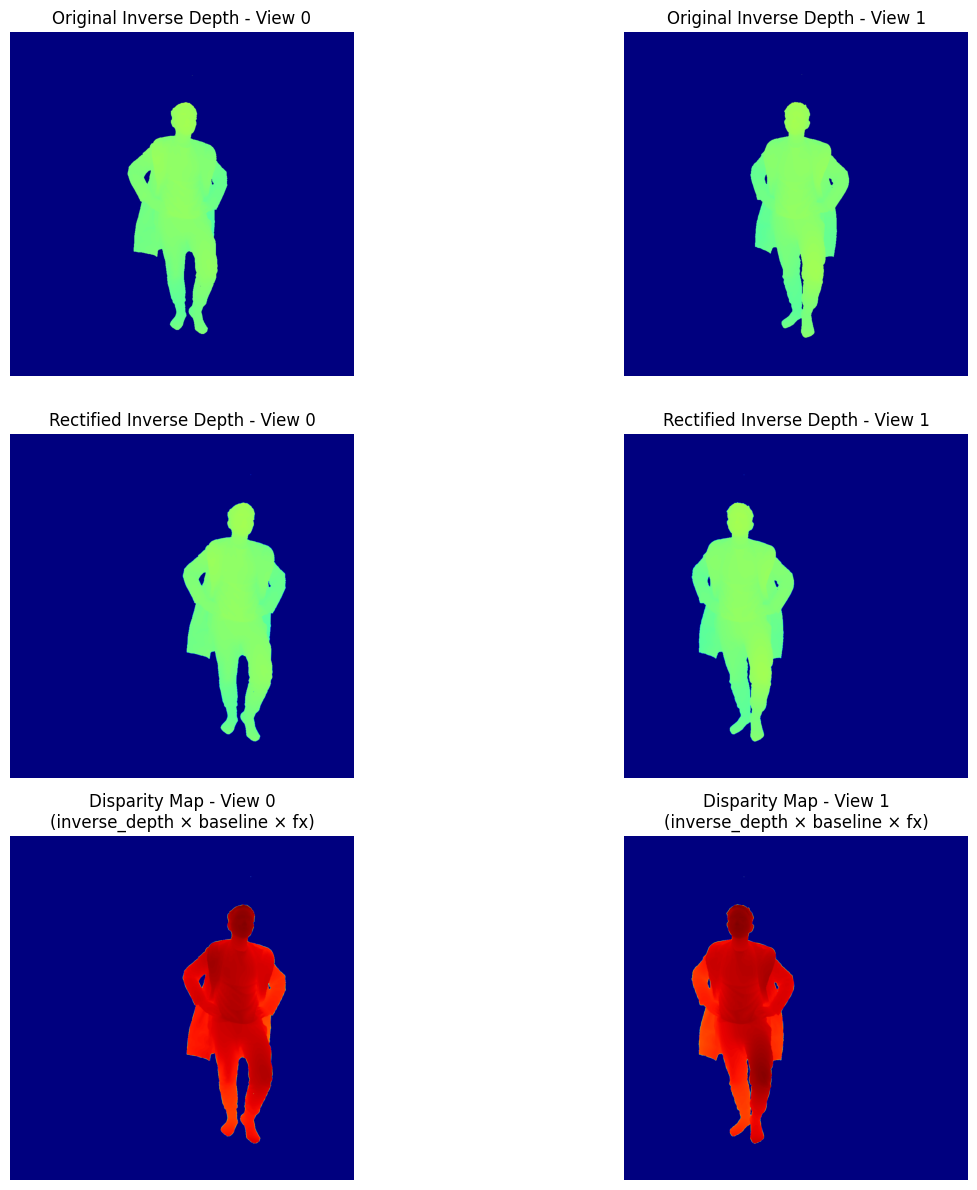


EXPLANATION:
1. INVERSE DEPTH: Stored as 1/Z (where Z is depth in meters)
   - Original: In unrectified camera coordinates
   - Rectified: After stereo rectification (epipolar lines horizontal)

2. DISPARITY: Horizontal pixel offset between corresponding points
   - Formula: disparity = inverse_depth × baseline × focal_length
   - Unit: pixels
   - Only meaningful for rectified images

3. RELATIONSHIP:
   - For this stereo pair:
     • Baseline = 0.7882 (distance between cameras)
     • Focal length (rectified) = 819.20 pixels
     • Scaling factor = 645.71
   - So: disparity ≈ inverse_depth × 645.71

4. GROUND TRUTH:
   - Rectified inverse depth maps ARE the ground truth for rectified images
   - They can be converted to disparity using the formula above
   - Useful for training stereo matching networks


In [77]:
# Rectify inverse depth maps and understand their relationship to disparity
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def load_inverse_depth(data_root, view_name, view_id):
    """Load inverse depth map (stored as uint16/2^15)"""
    depth_path = os.path.join(data_root, 'depth', view_name, f'{view_id}.png')
    inv_depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / (2**15)
    return inv_depth

def rectify_inverse_depth(inv_depth, map_x, map_y):
    """
    Rectify an inverse depth map using the same rectification maps as images
    """
    rect_inv_depth = cv2.remap(inv_depth, map_x, map_y, cv2.INTER_LINEAR)
    return rect_inv_depth

def inverse_depth_to_disparity(inv_depth, baseline, focal_length):
    """
    Convert inverse depth (1/Z) to disparity (pixels)
    
    For rectified stereo:
    - Disparity d = x_left - x_right (horizontal pixel difference)
    - Depth Z = (baseline * focal_length) / disparity
    - Therefore: disparity = baseline * focal_length / Z = baseline * focal_length * (1/Z)
    - So: disparity = inverse_depth * baseline * focal_length
    
    Args:
        inv_depth: Inverse depth map (1/Z)
        baseline: Distance between camera centers (meters or whatever unit)
        focal_length: Focal length in pixels (fx from rectified camera matrix)
    
    Returns:
        disparity: Disparity in pixels
    """
    disparity = inv_depth * baseline * focal_length
    return disparity

# Load the data
data_root = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train'
view_name = '0004_000'
view_id_0 = 0
view_id_1 = 1

# Load camera parameters
intr0, extr0 = load_camera_params(data_root, view_name, view_id_0)
intr1, extr1 = load_camera_params(data_root, view_name, view_id_1)

# Load images and masks
img0, mask0 = load_image_and_mask(data_root, view_name, view_id_0)
img1, mask1 = load_image_and_mask(data_root, view_name, view_id_1)

# Load inverse depth maps
inv_depth0 = load_inverse_depth(data_root, view_name, view_id_0)
inv_depth1 = load_inverse_depth(data_root, view_name, view_id_1)

print(f"Original inverse depth shapes: {inv_depth0.shape}, {inv_depth1.shape}")
print(f"Original inverse depth ranges:")
print(f"  View 0: [{inv_depth0.min():.4f}, {inv_depth0.max():.4f}]")
print(f"  View 1: [{inv_depth1.min():.4f}, {inv_depth1.max():.4f}]")

# Perform rectification using Central Axis method (from Cell 1)
H, W = img0.shape[:2]

# Extract rotation and translation
r0, t0 = extr0[:3, :3], extr0[:3, 3:]
r1, t1 = extr1[:3, :3], extr1[:3, 3:]

# Calculate baseline (Euclidean distance between camera centers)
# Camera 0 center: -r0.T @ t0
# Camera 1 center: -r1.T @ t1
cam0_center = (-r0.T @ t0).flatten()
cam1_center = (-r1.T @ t1).flatten()
baseline = np.linalg.norm(cam1_center - cam0_center)
print(f"\nBaseline (distance between cameras): {baseline:.4f}")

# No distortion
dist0 = np.zeros(4)
dist1 = np.zeros(4)

# Use Central Axis Rectification (from Cell 1)
print("\nUsing Central Axis Rectification (from Cell 1)...")
cams_info_rect = [
    {'K': intr0, 'width': W, 'height': H}, 
    {'K': intr1, 'width': W, 'height': H}
]
world_extrs_rect = [extr0, extr1]

# Call stereo_rectify_central_axis defined in Cell 1
R0, R1, P0, P1, Q = stereo_rectify_central_axis(cams_info_rect, world_extrs_rect, [0, 1])

print(f"Rectification matrices computed using Central Axis method")
print(f"P0:\n{P0}")
print(f"P1:\n{P1}")

# Compute rectification maps
map0_x, map0_y = cv2.initUndistortRectifyMap(intr0, dist0, R0, P0, (W, H), cv2.CV_32FC1)
map1_x, map1_y = cv2.initUndistortRectifyMap(intr1, dist1, R1, P1, (W, H), cv2.CV_32FC1)

# Rectify inverse depth maps
rect_inv_depth0 = rectify_inverse_depth(inv_depth0, map0_x, map0_y)
rect_inv_depth1 = rectify_inverse_depth(inv_depth1, map1_x, map1_y)

print(f"\nRectified inverse depth shapes: {rect_inv_depth0.shape}, {rect_inv_depth1.shape}")
print(f"Rectified inverse depth ranges:")
print(f"  View 0: [{rect_inv_depth0.min():.4f}, {rect_inv_depth0.max():.4f}]")
print(f"  View 1: [{rect_inv_depth1.min():.4f}, {rect_inv_depth1.max():.4f}]")

# Convert to disparity using rectified focal length
# P0 and P1 are the rectified projection matrices [fx' 0 cx' 0; 0 fy' cy' 0; 0 0 1 0]
fx_rect = P0[0, 0]
fy_rect = P0[1, 1]
print(f"\nRectified camera parameters:")
print(f"  fx': {fx_rect:.2f}, fy': {fy_rect:.2f}")

# Convert rectified inverse depth to disparity
disparity0 = inverse_depth_to_disparity(rect_inv_depth0, baseline, fx_rect)
disparity1 = inverse_depth_to_disparity(rect_inv_depth1, baseline, fx_rect)

print(f"\nDisparity ranges (in pixels):")
print(f"  View 0: [{disparity0.min():.2f}, {disparity0.max():.2f}]")
print(f"  View 1: [{disparity1.min():.2f}, {disparity1.max():.2f}]")

# Filter by mask to get meaningful statistics
mask0_bool = mask0 > 128
mask1_bool = mask1 > 128

valid_inv_depth0 = rect_inv_depth0[mask0_bool]
valid_inv_depth1 = rect_inv_depth1[mask1_bool]
valid_disparity0 = disparity0[mask0_bool]
valid_disparity1 = disparity1[mask1_bool]

# Filter out zero/very small values
valid_inv_depth0 = valid_inv_depth0[valid_inv_depth0 > 0.05]
valid_inv_depth1 = valid_inv_depth1[valid_inv_depth1 > 0.05]
valid_disparity0 = valid_disparity0[valid_disparity0 > 0]
valid_disparity1 = valid_disparity1[valid_disparity1 > 0]

print(f"\nMasked inverse depth statistics:")
print(f"  View 0: mean={valid_inv_depth0.mean():.4f}, median={np.median(valid_inv_depth0):.4f}")
print(f"  View 1: mean={valid_inv_depth1.mean():.4f}, median={np.median(valid_inv_depth1):.4f}")
print(f"\nMasked disparity statistics (pixels):")
print(f"  View 0: mean={valid_disparity0.mean():.2f}, median={np.median(valid_disparity0):.2f}")
print(f"  View 1: mean={valid_disparity1.mean():.2f}, median={np.median(valid_disparity1):.2f}")

# Convert to actual depth for reference
valid_depth0 = 1.0 / valid_inv_depth0
valid_depth1 = 1.0 / valid_inv_depth1
print(f"\nActual depth statistics (meters):")
print(f"  View 0: mean={valid_depth0.mean():.2f}m, median={np.median(valid_depth0):.2f}m")
print(f"  View 1: mean={valid_depth1.mean():.2f}m, median={np.median(valid_depth1):.2f}m")

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Row 1: Original inverse depth
axes[0, 0].imshow(inv_depth0, cmap='jet', vmin=0, vmax=1)
axes[0, 0].set_title(f'Original Inverse Depth - View {view_id_0}')
axes[0, 0].axis('off')

axes[0, 1].imshow(inv_depth1, cmap='jet', vmin=0, vmax=1)
axes[0, 1].set_title(f'Original Inverse Depth - View {view_id_1}')
axes[0, 1].axis('off')

# Row 2: Rectified inverse depth
axes[1, 0].imshow(rect_inv_depth0, cmap='jet', vmin=0, vmax=1)
axes[1, 0].set_title(f'Rectified Inverse Depth - View {view_id_0}')
axes[1, 0].axis('off')

axes[1, 1].imshow(rect_inv_depth1, cmap='jet', vmin=0, vmax=1)
axes[1, 1].set_title(f'Rectified Inverse Depth - View {view_id_1}')
axes[1, 1].axis('off')

# Row 3: Disparity maps
disp_max = max(disparity0.max(), disparity1.max())
axes[2, 0].imshow(disparity0, cmap='jet', vmin=0, vmax=disp_max)
axes[2, 0].set_title(f'Disparity Map - View {view_id_0}\n(inverse_depth × baseline × fx)')
axes[2, 0].axis('off')

axes[2, 1].imshow(disparity1, cmap='jet', vmin=0, vmax=disp_max)
axes[2, 1].set_title(f'Disparity Map - View {view_id_1}\n(inverse_depth × baseline × fx)')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EXPLANATION:")
print("="*70)
print("1. INVERSE DEPTH: Stored as 1/Z (where Z is depth in meters)")
print("   - Original: In unrectified camera coordinates")
print("   - Rectified: After stereo rectification (epipolar lines horizontal)")
print()
print("2. DISPARITY: Horizontal pixel offset between corresponding points")
print("   - Formula: disparity = inverse_depth × baseline × focal_length")
print("   - Unit: pixels")
print("   - Only meaningful for rectified images")
print()
print("3. RELATIONSHIP:")
print(f"   - For this stereo pair:")
print(f"     • Baseline = {baseline:.4f} (distance between cameras)")
print(f"     • Focal length (rectified) = {fx_rect:.2f} pixels")
print(f"     • Scaling factor = {baseline * fx_rect:.2f}")
print(f"   - So: disparity ≈ inverse_depth × {baseline * fx_rect:.2f}")
print()
print("4. GROUND TRUTH:")
print("   - Rectified inverse depth maps ARE the ground truth for rectified images")
print("   - They can be converted to disparity using the formula above")
print("   - Useful for training stereo matching networks")
print("="*70)

In [85]:
from __future__ import print_function, division

import argparse
import logging
import numpy as np
import cv2
import os
from pathlib import Path
from tqdm import tqdm

from lib.human_loader import StereoHumanDataset
from lib.network import RtStereoHumanModel
from config.stereo_human_config import ConfigStereoHuman as config
from lib.utils import get_novel_calib
from lib.GaussianRender import pts2render
from unimatch.dataloader.stereo import transforms
from unimatch.unimatch.unimatch import UniMatch
import torch.nn.functional as F
from torchvision.transforms.functional import hflip

import torch
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class StereoHumanRender:
    def __init__(self, cfg_file, phase):
        self.cfg = cfg_file
        self.bs = self.cfg.batch_size
        self.inference_size = self.cfg.unimatch.inference_size
        self.pred_bidir_disp = self.cfg.unimatch.pred_bidir_disp

        val_transform_list = [
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  #            transforms.ToTensor(),
        ]
        self.val_transform = transforms.Compose(val_transform_list)

        self.model = RtStereoHumanModel(self.cfg, with_gs_render=True)
        self.encoder = UniMatch(
            feature_channels=self.cfg.unimatch.feature_channels,
            num_scales=self.cfg.unimatch.num_scales,
            upsample_factor=self.cfg.unimatch.upsample_factor,
            num_head=self.cfg.unimatch.num_head,
            ffn_dim_expansion=self.cfg.unimatch.ffn_dim_expansion,
            num_transformer_layers=self.cfg.unimatch.num_transformer_layers,
            reg_refine=self.cfg.unimatch.reg_refine,
            task=self.cfg.unimatch.task,
        ).to(device)

        if self.cfg.unimatch.unimatch_ckpt:
            # Set weights_only=False to support legacy checkpoints / complex types
            checkpoint = torch.load(self.cfg.unimatch.unimatch_ckpt, map_location=device, weights_only=False)
            self.encoder.load_state_dict(checkpoint["model"], strict=True)

        self.model.to(device)
        if self.cfg.restore_ckpt:
            self.load_ckpt(self.cfg.restore_ckpt)
        self.model.eval()
        self.encoder.eval()
    
    def load_ckpt(self, load_path):
        # Set weights_only=False to support legacy checkpoints / complex types
        checkpoint = torch.load(load_path, map_location=device, weights_only=False)
        self.model.load_state_dict(checkpoint['network'], strict=True)
        print(f"Loaded checkpoint from {load_path}") 

    def run_unimatch_inference(self, item):  # this should run before fetch_data

        # match gen_novel_view.py: use img_ori.
        # Ensure img_ori is populated in preprocess_data_opencv as [0, 1] tensor.
        left, right = item["lmain"]["img_ori"].clone().detach(), item["rmain"]["img_ori"].clone().detach()

        # Remove batch dimension if it exists (from fetch_data)
        if left.dim() == 4:  # [1, 3, H, W] -> [3, H, W]
            left = left.squeeze(0)
        if right.dim() == 4:  # [1, 3, H, W] -> [3, H, W]
            right = right.squeeze(0)

        input_unimatch = {"left": left, "right": right}
        input_unimatch = self.val_transform(input_unimatch)
        left = input_unimatch["left"].to(device).unsqueeze(0)  # [1, 3, H, W]
        right = input_unimatch["right"].to(device).unsqueeze(0)  # [1, 3, H, W]

        # switch to f16
        left = left.half()
        right = right.half()

        # resize to nearest size or specified size
        # inference_size = (1024, 768)  # (H, W)

        ori_size = left.shape[-2:]
        if self.inference_size[0] != ori_size[0] or self.inference_size[1] != ori_size[1]:
            left = F.interpolate(left, size=self.inference_size, mode="bilinear", align_corners=True)
            right = F.interpolate(right, size=self.inference_size, mode="bilinear", align_corners=True)
        with torch.no_grad(), torch.amp.autocast(device.type, enabled=True):
            if self.pred_bidir_disp:
                new_left, new_right = hflip(right), hflip(left)
                left = torch.cat((left, new_left), dim=0)
                right = torch.cat((right, new_right), dim=0)
            else:
                 # Add missing else block to match gen_novel_view.py
                left = left.unsqueeze(0)
                right = right.unsqueeze(0)
                
            # Note: left and right already have batch dimension from unsqueeze(0) above
            # When pred_bidir_disp=True: [2, 3, H, W], when False: [1, 3, H, W]

            pred_disp = self.encoder(
                left,
                right,
                attn_type=self.cfg.unimatch.attn_type,
                attn_splits_list=self.cfg.unimatch.attn_splits_list,
                corr_radius_list=self.cfg.unimatch.corr_radius_list,
                prop_radius_list=self.cfg.unimatch.prop_radius_list,
                num_reg_refine=self.cfg.unimatch.num_reg_refine,
                task="stereo",
            )["flow_preds"][
                -1
            ]  # [1, H, W]

            if self.inference_size[0] != ori_size[0] or self.inference_size[1] != ori_size[1]:
                # resize back
                pred_disp = F.interpolate(
                    pred_disp.unsqueeze(1), size=ori_size, mode="bilinear", align_corners=True
                ).squeeze(
                    1
                )  # [2, H, W]
                pred_disp = pred_disp * ori_size[-1] / float(self.inference_size[-1])

            if self.pred_bidir_disp:
                assert pred_disp.size(0) == 2  # [2, H, W]

                # flip back
                pred_disp[1] = hflip(pred_disp[1])

        return pred_disp.unsqueeze(0)  # [1, 2, H, W] for left and right, stored in gpu

    """def infer_seqence(self, view_select, ratio=0.5):
        total_frames = len(os.listdir(os.path.join(self.cfg.dataset.test_data_root, 'img')))
        for idx in tqdm(range(total_frames)):
            item = self.dataset.get_test_item(idx, source_id=view_select)
            data = self.fetch_data(item)
            data = get_novel_calib(data, self.cfg.dataset, ratio=ratio, intr_key='intr_ori', extr_key='extr_ori')
            with torch.no_grad():
                data, _, _ = self.model(data, is_train=False)
                data = pts2render(data, bg_color=self.cfg.dataset.bg_color)

            render_novel = self.tensor2np(data['novel_view']['img_pred'])
            cv2.imwrite(self.cfg.test_out_path + '/%s_novel.jpg' % (data['name']), render_novel)"""
    
    def assign_unimatch_disp(
        self, data, unimatch_disp
    ):  # assign original unimatch disparity map. Unimatch_disp is of shape (bs, 2, h, w)

        baseline = data["lmain"]["extr"][:, 0, 3] - data["rmain"]["extr"][:, 0, 3]
        for i, view in enumerate(["lmain", "rmain"]):
            data[view]["depth_pred"] = unimatch_disp[:, i, ...].unsqueeze(0) / (
                baseline * data[view]["intr"][:, 0, 0]
            )  # use the left disparity map for depth prediction

        return data

    def tensor2np(self, img_tensor):
        img_np = img_tensor.permute(0, 2, 3, 1)[0].detach().cpu().numpy()
        img_np = img_np * 255
        img_np = img_np[:, :, ::-1].astype(np.uint8)
        return img_np
    
    def fetch_data(self, data):
        for view in ["lmain", "rmain"]:
            data[view]["img"] = 2 * (data[view]["img"] / 255.0) - 1.0  # normalize to [-1, 1] for norvel view rendering
            for item in data[view].keys():
                data[view][item] = data[view][item].to(device).unsqueeze(0)  # create a batch dimension
        return data
    
    def show_intermediate_results(self, item):
        """plt.figure(figsize=(20, 10))
        plt.title("input images and masks")
        i = 1
        for view in ["lmain", "rmain"]:
            img = item[view]["img"][0].cpu().numpy().transpose(1, 2, 0)
            mask = item[view]["mask"][0].cpu().numpy().transpose(1, 2, 0)
            img = (img + 1) / 2.0
            img[mask == 0] = 0.5
            plt.subplot(1, 2, i)
            plt.imshow(img)
            i += 1
        plt.show()"""
        

        plt.figure(figsize=(20, 10))
        plt.title("unimatch disparity maps")
        i = 1
        for view in ["lmain", "rmain"]:
            disp = item[view]["depth_pred"][0].cpu().numpy().squeeze()
            mask = item[view]["mask"][0].cpu().numpy().transpose(1, 2, 0)[:,:,0]
            disp[mask == 0] = 0
            plt.subplot(1, 2, i)
            plt.imshow(disp, cmap="gray")
            i += 1
        plt.show()

In [86]:
from torch.utils.data import Dataset
import json
import copy
# pad images to a target size and adjust intrinsic matrix accordingly
from scipy.spatial.transform import Rotation as R_
from scipy.spatial.transform import Slerp

def pad_image(image, target_size, pad_value=[230, 231, 235]):
    """
    Pad the image to the target size with a specific color.
    """
    channels = image.shape[2] if len(image.shape) == 3 else 1
    if channels > len(pad_value):
        # add alpha channel to pad value if not already present
        pad_value += [0] * (channels - len(pad_value))
    padded_image = np.full((target_size[0], target_size[1], channels), pad_value, dtype=image.dtype)
    # Compute padding offsets
    y_offset = (target_size[0] - image.shape[0]) // 2
    x_offset = (target_size[1] - image.shape[1]) // 2
    # Place the original image in the center
    padded_image[y_offset : y_offset + image.shape[0], x_offset : x_offset + image.shape[1]] = image

    return padded_image


def pad_cams(cams, target_size):
    """
    Pad the camera parameters to match the target size.
    """
    padded_cams = []
    for cam in cams:
        cam_copy = copy.deepcopy(cam)
        cam_copy["K"][0, 2] += (target_size[1] - cam["width"]) / 2  # Adjust cx
        cam_copy["K"][1, 2] += (target_size[0] - cam["height"]) / 2  # Adjust cy
        cam_copy["width"] = target_size[1]
        cam_copy["height"] = target_size[0]
        padded_cams.append(cam_copy)
    return padded_cams

def correct_camera_poses(cams_info: list):
    # make a copy of the camera poses
    cams_copy = copy.deepcopy(cams_info)
    # change the camera poses to facing inward
    for cam in cams_copy:
        # flip the y and z axis
        cam["M"][:, 1] = -cam["M"][:, 1]
        cam["M"][:, 2] = -cam["M"][:, 2]

    return cams_copy


# transform camera poses to world cam projection matrix
def world_to_camera(cams_info: list):
    # convert the camera poses world to camera matrix

    world_to_camera_matrices = []
    for cam in cams_info:
        # get the camera extrinsic matrix
        R = cam["M"][:3, :3].copy()
        t = cam["M"][:3, 3].copy()

        R_transposed = R.T
        t_new = -R_transposed @ t

        world_to_camera_matrix = np.eye(4)
        world_to_camera_matrix[:3, :3] = R_transposed
        world_to_camera_matrix[:3, 3] = t_new
        world_to_camera_matrices.append(world_to_camera_matrix)
    return world_to_camera_matrices

def get_cams_rectified(cams, sorted_indices, alpha=1, scale_factor=1):
    # alpha should be set as 0.5 for a 20deg yaw and 0.6m baseline
    # scale_factor should be set as 1 for 1080p input, but need to go down if seperation is too large to stablize cv2.stereoRectify()
    # cameras should have been padded to increase flexibility of rectification

    # correct camera poses by rotating around the x axis by 180 degrees
    cams_copy = correct_camera_poses(cams)
    world_to_camera_matrices = world_to_camera(cams_copy)

    cams_rectified = []
    for i in range(len(sorted_indices) - 1):

        R1_rect, R2_rect, P1_rect, P2_rect, *_ = stereo_rectify_central_axis(
            cams,
            world_to_camera_matrices,
            [sorted_indices[i], sorted_indices[i + 1]],
        )
        new_extr1 = R1_rect @ world_to_camera_matrices[sorted_indices[i]][:3, :]  # oringally new_extr0 = R0 @ extr0
        new_extr1 = np.vstack([new_extr1, np.array([[0, 0, 0, 1]])])
        new_intr1 = P1_rect[:3, :3]

        new_extr2 = R2_rect @ world_to_camera_matrices[sorted_indices[i + 1]][:3, :]
        new_intr2 = P2_rect[:3, :3]
        new_extr2 = np.vstack([new_extr2, np.array([[0, 0, 0, 1]])])

        # Get the intrinsic matrices
        K1 = cams[sorted_indices[i]]["K"]
        K2 = cams[sorted_indices[i + 1]]["K"]

        disp_shape = (
            int(cams[sorted_indices[i]]["width"] * scale_factor),
            int(cams[sorted_indices[i]]["height"] * scale_factor),
        )

        # Rectify the images
        map1x, map1y = cv2.initUndistortRectifyMap(K1, np.zeros((5, 1)), R1_rect, P1_rect, disp_shape, cv2.CV_32FC1)
        map2x, map2y = cv2.initUndistortRectifyMap(K2, np.zeros((5, 1)), R2_rect, P2_rect, disp_shape, cv2.CV_32FC1)

        cams_rectified.append(
            {
                "left": {
                    "M": new_extr1.astype(np.float32),
                    "K": new_intr1.astype(np.float32),
                    "M_original": world_to_camera_matrices[sorted_indices[i]].astype(np.float32),
                    "K_original": K1.astype(np.float32),
                    "P": P1_rect,
                    "R": R1_rect,
                    "mapx": map1x,
                    "mapy": map1y,
                },
                "right": {
                    "M": new_extr2.astype(np.float32),
                    "K": new_intr2.astype(np.float32),
                    "M_original": world_to_camera_matrices[sorted_indices[i + 1]].astype(np.float32),
                    "K_original": K2.astype(np.float32),
                    "P": P2_rect,
                    "R": R2_rect,
                    "mapx": map2x,
                    "mapy": map2y,
                },
            }
        )
    return cams_rectified

In [87]:
class StreamData(Dataset):
    def __init__(self, opt=None):
        self.opt = opt
        self.rectification_cache = {}  # (cam_id_1, cam_id_2) : cams_rectified

    def preprocess_data(self, camera_data: dict[str, np.ndarray], debug_mode=False, target_size=(1024, 1024)):
        """
        Preprocess the input camera data to prepare it for novel view generation.

        Args:
            camera_data (dict[str, np.ndarray]): A dictionary with camera IDs as keys, data as values.
                Each value should contain the following keys:
                - "K": Intrinsic matrix (3x3 numpy array)
                - "M": Extrinsic matrix (4x4 numpy array)
                - "frame": Image data (H x W x 3 or 4 numpy array)
                - "width": Image width (int)
                - "height": Image height (int)
                - "distortion_params": Distortion parameters k1, k2, p1, p2, k3 (numpy array)
            debug_mode (bool): If True, enables additional debugging features.
            target_size (tuple): Target size (height, width) to pad images to.
        Returns:
            dict: A preprocessed data item ready for novel view generation.
        """
        cams = list(camera_data.values())
        cam_ids = list(camera_data.keys())
        images = [cam["frame"] for cam in cams]
        # sorted_indices, yaw_angles_sorted = sort_by_yaw(camera_data.values())

        img1 = pad_image(images[0], target_size)
        img2 = pad_image(images[1], target_size)
        cache_key = tuple(sorted(cam_ids))
        if cache_key in self.rectification_cache:
            # if we have already seen this camera pair, used cached rectification
            cams_rectified = self.rectification_cache[cache_key]
        else:
            # otherwise compute rectification and cache it
            cams_padded = pad_cams(cams, target_size=target_size)
            cams_rectified = get_cams_rectified(cams_padded, [0, 1], alpha=0.5, scale_factor=1.0)
            self.rectification_cache[cache_key] = cams_rectified
        rectified_data = self.get_data_from_stream(
            (img1, img2), cams_rectified[0], rectify=True, batch_size=1, background=(230, 231, 235), threshold_mask=30
        )

        if debug_mode:
            # visualize in tmp directory
            img_original = np.hstack((images[0], images[1]))
            img_padded = np.hstack((img1, img2))
            img_rectified = np.hstack(
                (
                    rectified_data["lmain"]["img"].permute(1, 2, 0).cpu().numpy(),
                    rectified_data["rmain"]["img"].permute(1, 2, 0).cpu().numpy(),
                )
            )
            cv2.imwrite("tmp/original.png", cv2.cvtColor(img_original, cv2.COLOR_RGBA2BGR))
            cv2.imwrite("tmp/padded.png", cv2.cvtColor(img_padded, cv2.COLOR_RGBA2BGR))
            cv2.imwrite("tmp/rectified.png", cv2.cvtColor(img_rectified, cv2.COLOR_RGB2BGR))

            # save camera matrices for reference
            camera_matrices = {
                "original": {
                    "K1": cams[0]["K"].tolist(),
                    "M1": cams[0]["M"].tolist(),
                    "K2": cams[1]["K"].tolist(),
                    "M2": cams[1]["M"].tolist(),
                },
                "padded": {
                    "K1": cams_padded[0]["K"].tolist(),
                    "M1": cams_padded[0]["M"].tolist(),
                    "K2": cams_padded[1]["K"].tolist(),
                    "M2": cams_padded[1]["M"].tolist(),
                },
                "rectified": {
                    "K1": cams_rectified[0]["left"]["K"].tolist(),
                    "M1": cams_rectified[0]["left"]["M"].tolist(),
                    "K2": cams_rectified[0]["right"]["K"].tolist(),
                    "M2": cams_rectified[0]["right"]["M"].tolist(),
                },
            }
            with open("tmp/camera_matrices.json", "w") as f:
                json.dump(camera_matrices, f, indent=4)

        return rectified_data

    def get_data_from_stream(
        self, img_pair, cam_pair, rectify=True, background=[0, 0, 0], threshold_mask=5, batch_size=1
    ):  # may nextend to larger batch sizes
        # background color [0 255]
        # threshold for mask creation

        if img_pair[0].shape[2] == 4:  # if containing alpha channel, create a masked image
            mask1 = img_pair[0][:, :, 3:4] / 255.0
            mask1[mask1 < 1] = 0
            img1 = img_pair[0][:, :, :3] * mask1
            img1[(img1[:, :, 0] == 0) & (img1[:, :, 1] == 0) & (img1[:, :, 2] == 0)] = background

            mask2 = img_pair[1][:, :, 3:4] / 255.0
            mask2[mask2 < 1] = 0
            img2 = img_pair[1][:, :, :3] * mask2
            img2[(img2[:, :, 0] == 0) & (img2[:, :, 1] == 0) & (img2[:, :, 2] == 0)] = background
        else:
            img1 = img_pair[0].copy()
            img2 = img_pair[1].copy()

        if rectify:
            rectified_img1 = cv2.remap(
                img1.astype(np.float32),
                cam_pair["left"]["mapx"],
                cam_pair["left"]["mapy"],
                interpolation=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=(background[0], background[1], background[2]),
            )
            rectified_img2 = cv2.remap(
                img2.astype(np.float32),
                cam_pair["right"]["mapx"],
                cam_pair["right"]["mapy"],
                interpolation=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=(background[0], background[1], background[2]),
            )
        else:
            rectified_img1 = img1.copy()
            rectified_img2 = img2.copy()

        # create rectified masks. Rectifying masks seems to take longer time than simply binarizing rectified images
        xyz_mask_l = np.ones_like(rectified_img1[:, :, 0])
        xyz_mask_l[
            (np.abs(rectified_img1[..., 0] - background[0]) < threshold_mask)
            & (np.abs(rectified_img1[..., 1] - background[1]) < threshold_mask)
            & (np.abs(rectified_img1[..., 2] - background[2]) < threshold_mask)
        ] = 0
        xyz_mask_r = np.ones_like(rectified_img2[:, :, 0])
        xyz_mask_r[
            (np.abs(rectified_img2[..., 0] - background[0]) < threshold_mask)
            & (np.abs(rectified_img2[..., 1] - background[1]) < threshold_mask)
            & (np.abs(rectified_img2[..., 2] - background[2]) < threshold_mask)
        ] = 0

        #apply erosion to masks to shrink valid regions slightly and remove noise
        kernel = np.ones((3, 3), np.uint8)
        xyz_mask_l = cv2.erode(xyz_mask_l.astype(np.uint8), kernel, iterations=5)
        xyz_mask_r = cv2.erode(xyz_mask_r.astype(np.uint8), kernel, iterations=5)

        item = self.get_test_item_memory(
            img_pair=(rectified_img1, rectified_img2),
            msk_pair=(xyz_mask_l, xyz_mask_r),
            K_pair=(cam_pair["left"]["K"], cam_pair["right"]["K"]),
            M_pair=(cam_pair["left"]["M"], cam_pair["right"]["M"]),
            K_pair_ori=(cam_pair["left"]["K_original"], cam_pair["right"]["K_original"]),
            M_pair_ori=(cam_pair["left"]["M_original"], cam_pair["right"]["M_original"]),
        )

        return item

    def get_test_item_memory(
        self, img_pair, msk_pair, K_pair, M_pair, K_pair_ori=None, M_pair_ori=None, frameid="0", require_mask=True
    ):
        # img_pair: [img0, img1], msk_pair: [msk0, msk1], K_pair: [K0, K1], M_pair: [M0, M1]

        lmain_intr_ori, rmain_intr_ori = (
            (K_pair_ori[0], K_pair_ori[1]) if K_pair_ori is not None else (K_pair[0], K_pair[1])
        )
        lmain_extr_ori, rmain_extr_ori = (
            (M_pair_ori[0], M_pair_ori[1]) if M_pair_ori is not None else (M_pair[0], M_pair[1])
        )

        mask_0, pts_0 = None, None
        mask_1, pts_1 = None, None
        left_0, right_0, face_0 = torch.zeros(21, 2), torch.zeros(21, 2), torch.zeros(19, 3)
        left_1, right_1, face_1 = torch.zeros(21, 2), torch.zeros(21, 2), torch.zeros(19, 3)

        if require_mask:
            mask_0 = np.stack([msk_pair[0], msk_pair[0], msk_pair[0]], axis=-1)
            mask_1 = np.stack([msk_pair[1], msk_pair[1], msk_pair[1]], axis=-1)

        camera = {
            "intr0": K_pair[0],
            "intr1": K_pair[1],
            "extr0": M_pair[0],
            "extr1": M_pair[1],
        }

        stereo_data = {
            "img0": img_pair[0],
            "mask0": mask_0,
            "left0": left_0,
            "right0": right_0,
            "face0": face_0,
            "img1": img_pair[1],
            "mask1": mask_1,
            "camera": camera,
            "left1": left_1,
            "right1": right_1,
            "face1": face_1,
        }

        dict_tensor = self.stereo_to_dict_tensor(stereo_data, frameid)

        dict_tensor["lmain"]["intr_ori"] = torch.FloatTensor(lmain_intr_ori)
        dict_tensor["rmain"]["intr_ori"] = torch.FloatTensor(rmain_intr_ori)
        dict_tensor["lmain"]["extr_ori"] = torch.FloatTensor(lmain_extr_ori)
        dict_tensor["rmain"]["extr_ori"] = torch.FloatTensor(rmain_extr_ori)

        # img_len = 2048 if self.opt.use_hr_img else 1024
        img_len = 1024
        novel_dict = {"height": torch.IntTensor([img_len]), "width": torch.IntTensor([img_len])}

        dict_tensor.update({"novel_view": novel_dict})

        return dict_tensor

    def stereo_to_dict_tensor(self, stereo_data, subject_name):
        img_tensor, mask_tensor = [], []
        for img_view, mask_view in [("img0", "mask0"), ("img1", "mask1")]:
            img = torch.from_numpy(stereo_data[img_view]).permute(2, 0, 1).float()

            # comment the following line out because unimatch assumes a different pixel distribution; 0-255
            # img = 2 * (img / 255.0) - 1.0

            mask = torch.from_numpy(stereo_data[mask_view]).permute(2, 0, 1).float()
            # mask = mask /255.0

            # img = img * mask

            # need to change the following two lines for green background
            # mask[mask < 0.5] = 0.0
            # mask[mask >= 0.5] = 1.0

            img_tensor.append(img)
            mask_tensor.append(mask)

        lmain_data = {
            "img": img_tensor[0],
            "mask": mask_tensor[0],
            "intr": torch.FloatTensor(stereo_data["camera"]["intr0"]),
            "ref_intr": torch.FloatTensor(stereo_data["camera"]["intr1"]),
            "extr": torch.FloatTensor(stereo_data["camera"]["extr0"]),
            "left": stereo_data["left0"],
            "right": stereo_data["right0"],
            "face": stereo_data["face0"],
            "img_ori": img_tensor[0].clone(),
            "mask_ori": mask_tensor[0].clone(),
        }

        rmain_data = {
            "img": img_tensor[1],
            "mask": mask_tensor[1],
            "intr": torch.FloatTensor(stereo_data["camera"]["intr1"]),
            "ref_intr": torch.FloatTensor(stereo_data["camera"]["intr0"]),
            "extr": torch.FloatTensor(stereo_data["camera"]["extr1"]),
            "left": stereo_data["left1"],
            "right": stereo_data["right1"],
            "face": stereo_data["face1"],
            "img_ori": img_tensor[1].clone(),
            "mask_ori": mask_tensor[1].clone(),
        }

        if "flow0" in stereo_data:
            flow_tensor, valid_tensor = [], []
            for flow_view, valid_view in [("flow0", "valid0"), ("flow1", "valid1")]:
                flow = torch.from_numpy(stereo_data[flow_view])
                flow = torch.unsqueeze(flow, dim=0)
                flow_tensor.append(flow)

                valid = torch.from_numpy(stereo_data[valid_view])
                valid = torch.unsqueeze(valid, dim=0)
                valid = valid / 255.0
                valid_tensor.append(valid)

            lmain_data["flow"], lmain_data["valid"] = flow_tensor[0], valid_tensor[0]
            rmain_data["flow"], rmain_data["valid"] = flow_tensor[1], valid_tensor[1]

        if "depth0" in stereo_data:
            depth_tensor = []
            for depth_view in ["depth0", "depth1"]:
                depth = torch.from_numpy(stereo_data[depth_view])
                depth = torch.unsqueeze(depth, dim=0)
                depth_tensor.append(depth)

            lmain_data["depth"] = depth_tensor[0]
            rmain_data["depth"] = depth_tensor[1]

        return {"name": subject_name, "lmain": lmain_data, "rmain": rmain_data}

## OpenCV-Specific Data Preprocessing

The original `preprocess_data()` method expects a different camera format. Since our dataset uses **OpenCV world-to-camera extrinsic matrices** (3x4 `[R|t]` format), we need a custom preprocessing method that:

1. Directly handles OpenCV camera format (3x3 intrinsic + 3x4 extrinsic)
2. Uses `cv2.stereoRectify()` for proper rectification
3. Adjusts intrinsics when resizing images
4. Computes rectified extrinsics by applying rotation matrices
5. Prepares data in the format expected by the model

The key difference is in how camera transformations are handled - the original method may assume a different coordinate system or transformation convention.

Original images: (1024, 1024, 3), (1024, 1024, 3)
Original masks: (1024, 1024), (1024, 1024)
Intrinsic 0:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]
Intrinsic 1:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]
Extrinsic 0 shape: (3, 4)
Extrinsic 1 shape: (3, 4)

Running Central Axis Rectification (following Cell 1 pattern)...
Using View 0 as Left and View 1 as Right input.
Rectification matrices computed
P0:
[[819.2   0.  512.    0. ]
 [  0.  819.2 537.    0. ]
 [  0.    0.    1.    0. ]]
P1:
[[ 819.2           0.          512.         -645.71162867]
 [   0.          819.2         537.            0.        ]
 [   0.            0.            1.            0.        ]]
Rectified image shapes: (1024, 1024, 3), (1024, 1024, 3)
Rectified image range: [0, 255]
Baseline: 0.7882
Rectified focal length: 819.20

Running UniMatch Inference...
Initializing StereoHumanRender...
Loaded checkpoint from pretrained/GPS-GS_stage2_final.pth
Input image range before in

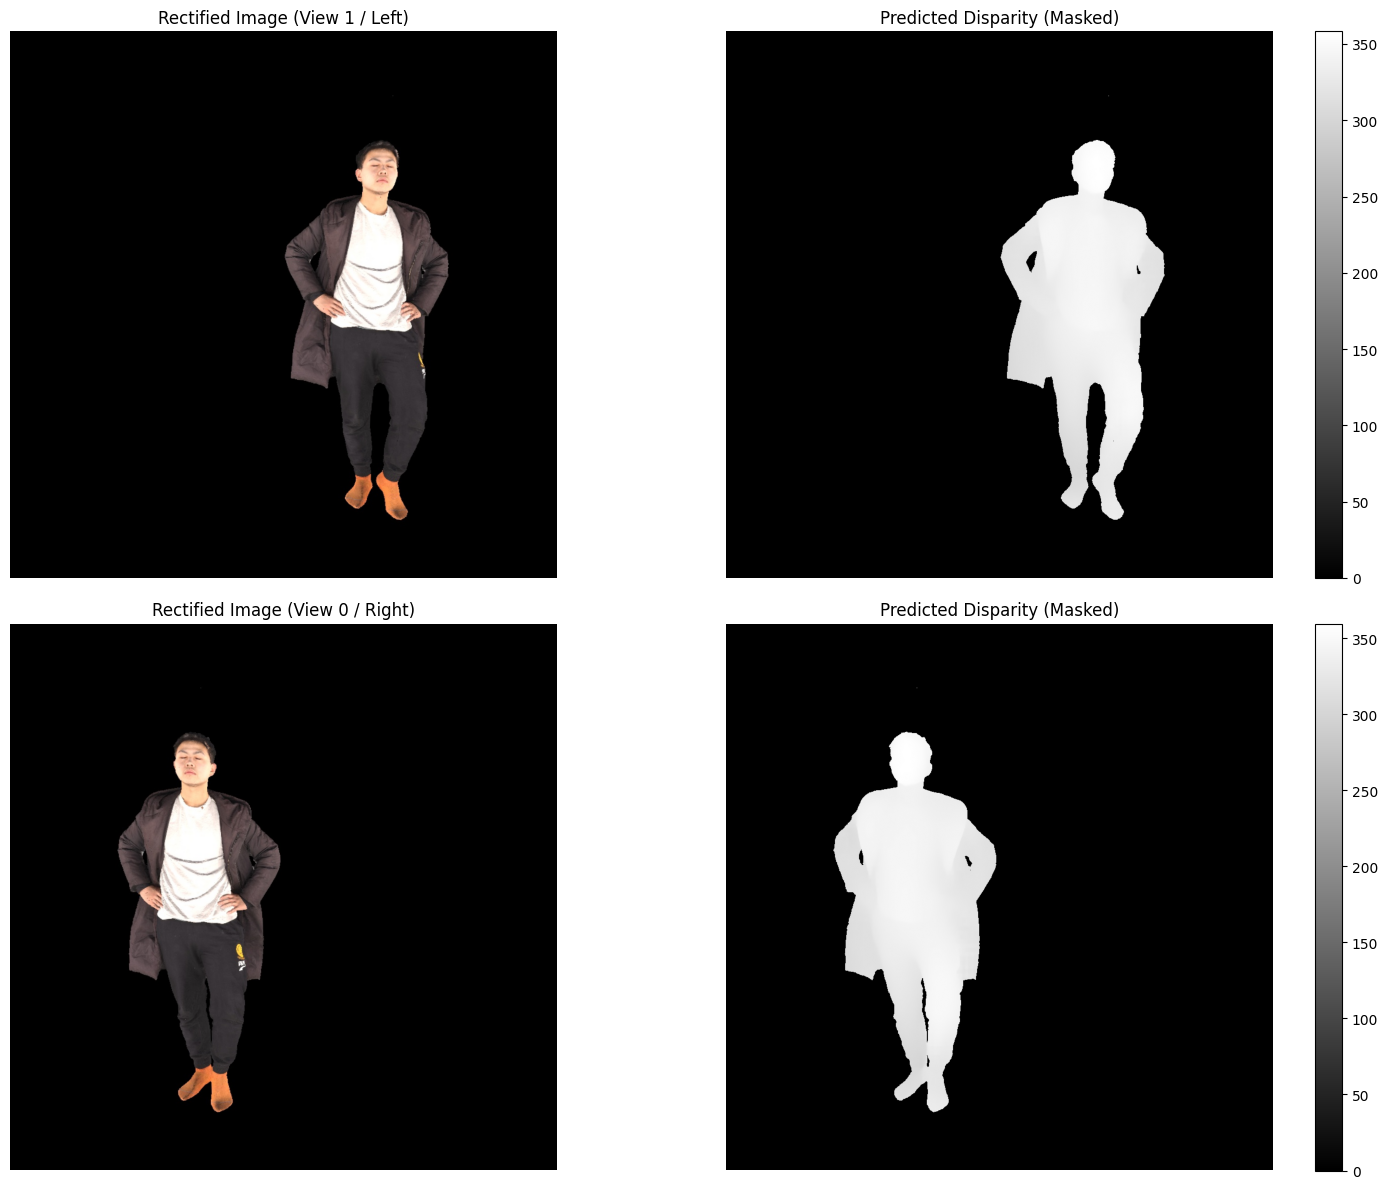


CROSS-SECTION ANALYSIS (View 1 / Left Prediction vs GT)
Loading Ground Truth depth from: d:\GitHub\GPS-Gaussian\render_data\render_data\train\depth\0004_000\0.png
Using Central Axis Rectification for GT...


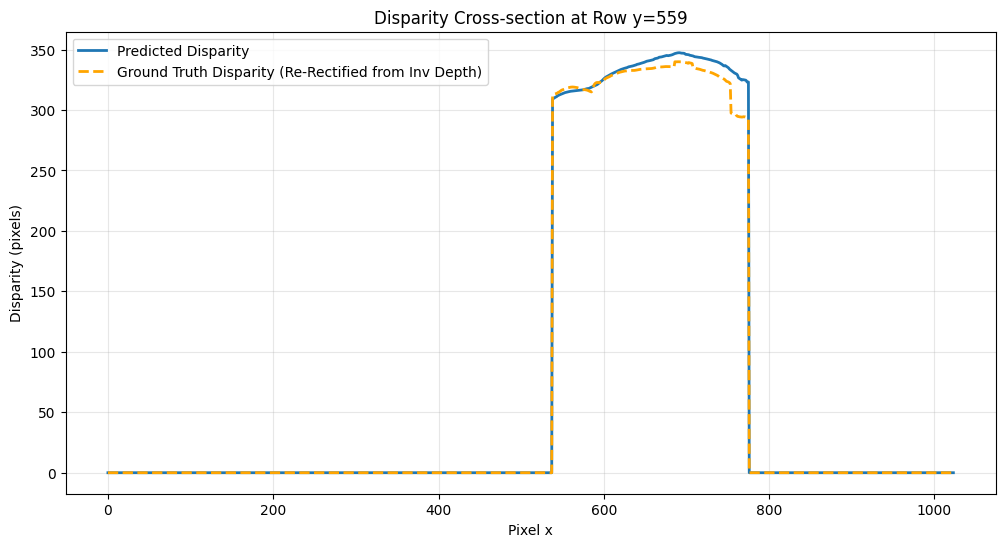

MAE on row 559: 8.0692 pixels
Pred Mean: 332.57, GT Mean: 325.45
Mean GT/Pred Ratio: 0.9789

Rectified image shapes: (1024, 1024, 3), (1024, 1024, 3)
Rectified mask shapes: (1024, 1024), (1024, 1024)

Rectified Intrinsic Left:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]
Rectified Intrinsic Right:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]

Rectified Extrinsic Left:
[[ 9.88220842e-01  5.53942587e-16  1.53034529e-01  3.94111101e-01]
 [-2.12982899e-02 -9.90268069e-01  1.37533759e-01  8.47130079e-01]
 [ 1.51545207e-01 -1.39173101e-01 -9.78603545e-01  2.11985834e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rectified Extrinsic Right:
[[ 9.88220842e-01  5.68871270e-16  1.53034529e-01 -3.94111101e-01]
 [-2.12982899e-02 -9.90268069e-01  1.37533759e-01  8.47130079e-01]
 [ 1.51545207e-01 -1.39173101e-01 -9.78603545e-01  2.11985834e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Baseline (x-direction): 0

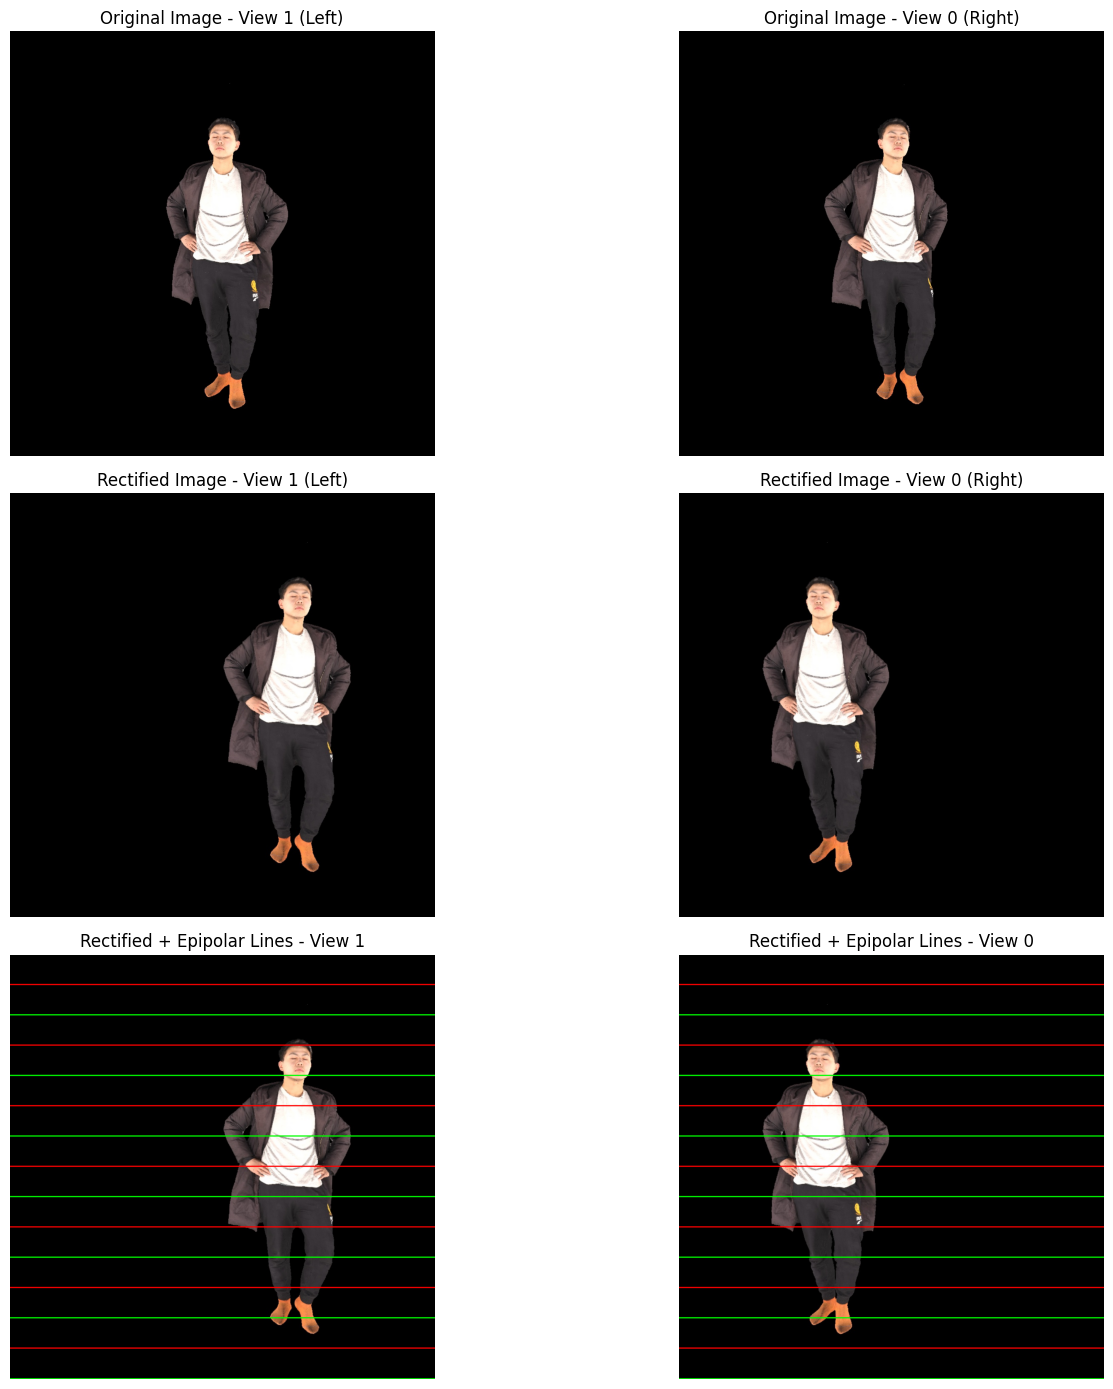


VERIFICATION:
✓ If epipolar lines are horizontal and aligned between left/right views,
  the rectification is correct.
✓ Check that corresponding features (e.g., shoulders, head) are on the same
  horizontal line in both images.


In [88]:
# Step-by-step debugging: Test rectification only
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialize the dataset class
stream_data_test = StreamData()

# Load images for testing
data_root = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train'
view_name = '0004_000'
view_id_0 = 0
view_id_1 = 1

# Load camera parameters
intr0, extr0 = load_camera_params(data_root, view_name, view_id_0)
intr1, extr1 = load_camera_params(data_root, view_name, view_id_1)

# Load images and masks
img0, mask0 = load_image_and_mask(data_root, view_name, view_id_0)
img1, mask1 = load_image_and_mask(data_root, view_name, view_id_1)

print(f"Original images: {img0.shape}, {img1.shape}")
print(f"Original masks: {mask0.shape}, {mask1.shape}")
print(f"Intrinsic 0:\n{intr0}")
print(f"Intrinsic 1:\n{intr1}")
print(f"Extrinsic 0 shape: {extr0.shape}")
print(f"Extrinsic 1 shape: {extr1.shape}")

# Run rectification using stereo_rectify_central_axis (same as Cell 1)
print("\n" + "="*70)
print("Running Central Axis Rectification (following Cell 1 pattern)...")
print("="*70)

# Use the SAME approach as Cell 1 - direct call to stereo_rectify_central_axis
print("Using View 0 as Left and View 1 as Right input.")

# Prepare data exactly like Cell 1
H, W = img0.shape[:2]
cams_info_inference = [
    {'K': intr0, 'width': W, 'height': H},
    {'K': intr1, 'width': W, 'height': H}
]

# Extrinsics as loaded (world-to-camera format)
if extr0.shape[0] == 3:
    extr0_4x4 = np.vstack([extr0, [0, 0, 0, 1]])
else:
    extr0_4x4 = extr0
    
if extr1.shape[0] == 3:
    extr1_4x4 = np.vstack([extr1, [0, 0, 0, 1]])
else:
    extr1_4x4 = extr1

world_cam_extrs_inference = [extr0_4x4, extr1_4x4]
cam_ids_inference = [0, 1]

# Call stereo_rectify_central_axis exactly like Cell 1
R0_rect_inf, R1_rect_inf, P0_rect_inf, P1_rect_inf, Q_inf = stereo_rectify_central_axis(
    cams_info_inference, world_cam_extrs_inference, cam_ids_inference
)

print(f"Rectification matrices computed")
print(f"P0:\n{P0_rect_inf}")
print(f"P1:\n{P1_rect_inf}")

# Create rectification maps
dist0 = np.zeros(4)
dist1 = np.zeros(4)

map0_x_inf, map0_y_inf = cv2.initUndistortRectifyMap(intr0, dist0, R0_rect_inf, P0_rect_inf, (W, H), cv2.CV_32FC1)
map1_x_inf, map1_y_inf = cv2.initUndistortRectifyMap(intr1, dist1, R1_rect_inf, P1_rect_inf, (W, H), cv2.CV_32FC1)

# Apply rectification to images
rect_img0_inf = cv2.remap(img0, map0_x_inf, map0_y_inf, cv2.INTER_LINEAR)
rect_img1_inf = cv2.remap(img1, map1_x_inf, map1_y_inf, cv2.INTER_LINEAR)

# Apply rectification to masks
rect_mask0_inf = cv2.remap(mask0, map0_x_inf, map0_y_inf, cv2.INTER_LINEAR)
rect_mask1_inf = cv2.remap(mask1, map1_x_inf, map1_y_inf, cv2.INTER_LINEAR)

# Create binary masks
maskL_binary_inf = rect_mask0_inf > 128
maskR_binary_inf = rect_mask1_inf > 128

# Prepare tensors for UniMatch (need to match expected format)
# Convert to tensors and normalize for UniMatch
rect_img0_tensor = torch.from_numpy(rect_img0_inf).permute(2, 0, 1).float() / 255.0  # [3, H, W], [0, 1]
rect_img1_tensor = torch.from_numpy(rect_img1_inf).permute(2, 0, 1).float() / 255.0

# Create mask tensors (3-channel)
rect_mask0_3ch = np.stack([rect_mask0_inf, rect_mask0_inf, rect_mask0_inf], axis=-1)
rect_mask1_3ch = np.stack([rect_mask1_inf, rect_mask1_inf, rect_mask1_inf], axis=-1)
rect_mask0_tensor = torch.from_numpy(rect_mask0_3ch).permute(2, 0, 1).float() / 255.0
rect_mask1_tensor = torch.from_numpy(rect_mask1_3ch).permute(2, 0, 1).float() / 255.0

# Compute rectified extrinsics (for reference)
rect_extr0_inf = np.eye(4)
rect_extr0_inf[:3, :] = R0_rect_inf @ extr0_4x4[:3, :]
rect_extr1_inf = np.eye(4)
rect_extr1_inf[:3, :] = R1_rect_inf @ extr1_4x4[:3, :]

# Create data_item_test structure manually
data_item_test = {
    'lmain': {
        'img': rect_img0_tensor * 255.0,  # Back to [0, 255] for display
        'img_ori': rect_img0_tensor,  # [0, 1] for UniMatch
        'mask': rect_mask0_tensor,
        'intr': torch.FloatTensor(P0_rect_inf[:3, :3]),
        'extr': torch.FloatTensor(rect_extr0_inf),
        'intr_ori': torch.FloatTensor(intr0),
        'extr_ori': torch.FloatTensor(extr0_4x4)
    },
    'rmain': {
        'img': rect_img1_tensor * 255.0,
        'img_ori': rect_img1_tensor,
        'mask': rect_mask1_tensor,
        'intr': torch.FloatTensor(P1_rect_inf[:3, :3]),
        'extr': torch.FloatTensor(rect_extr1_inf),
        'intr_ori': torch.FloatTensor(intr1),
        'extr_ori': torch.FloatTensor(extr1_4x4)
    },
    'novel_view': {
        'height': torch.IntTensor([H]),
        'width': torch.IntTensor([W])
    }
}

# For visualization
rect_imgL_vis = rect_img0_inf
rect_imgR_vis = rect_img1_inf


print(f"Rectified image shapes: {rect_imgL_vis.shape}, {rect_imgR_vis.shape}")
print(f"Rectified image range: [{rect_imgL_vis.min()}, {rect_imgL_vis.max()}]")

# Compute baseline for reference
baseline_inf = np.linalg.norm((-r0.T @ t0) - (-r1.T @ t1))
print(f"Baseline: {baseline_inf:.4f}")
print(f"Rectified focal length: {P0_rect_inf[0, 0]:.2f}")

# --- UniMatch Inference ---
# Use the StereoHumanRender class to predict disparity
from config.transformer_human_config import ConfigStereoHuman as config
import os
import torch

print("\n" + "="*70)
print("Running UniMatch Inference...")
print("="*70)

# Initialize renderer if needed

print("Initializing StereoHumanRender...")
cfg = config()
cfg_for_test = os.path.join('./config', 'small_cap.yaml')
cfg.load(cfg_for_test)
cfg = cfg.get_cfg()
cfg.defrost()
cfg.batch_size = 1
cfg.dataset.use_processed_data = False
cfg.restore_ckpt = 'pretrained/GPS-GS_stage2_final.pth'
cfg.unimatch.unimatch_ckpt = 'unimatch/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth'
cfg.freeze()
renderer = StereoHumanRender(cfg, phase='test')

# Check input range
print(f"Input image range before inference: [{data_item_test['lmain']['img_ori'].min():.2f}, {data_item_test['lmain']['img_ori'].max():.2f}]")
print("Keeping input in [0, 255] float format as requested.")

# Run inference
renderer.pred_bidir_disp = True

try:
    with torch.no_grad():
        unimatch_disp = renderer.run_unimatch_inference(data_item_test)
    
    print(f"Disparity shape: {unimatch_disp.shape}")
    print(f"Disparity range: [{unimatch_disp.min().item():.2f}, {unimatch_disp.max().item():.2f}]")

    # Retrieve disparity for visualization
    dispL = unimatch_disp[0, 0].cpu().numpy()
    dispR = unimatch_disp[0, 1].cpu().numpy()

    # Calculate inverse depth
    # inv_depth = disparity / (baseline * fx)
    baseline_inf_calc = np.linalg.norm((-r0.T @ t0) - (-r1.T @ t1))
    fx_inf = P0_rect_inf[0, 0]
    pred_inv_depthL = dispL / (baseline_inf_calc * fx_inf)
    pred_inv_depthR = dispR / (baseline_inf_calc * fx_inf)
    
    # Apply masks to DISPARITY
    # Extract masks for masking the disparity
    dispL_masked = dispL.copy()
    dispL_masked[~maskL_binary_inf] = 0
    
    dispR_masked = dispR.copy()
    dispR_masked[~maskR_binary_inf] = 0

    print(f"Predicted Disparity Range (Masked): [{dispL_masked[maskL_binary_inf].min():.4f}, {dispL_masked[maskL_binary_inf].max():.4f}]")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Left View (View 1)
    axes[0, 0].imshow(rect_imgL_vis)
    axes[0, 0].set_title('Rectified Image (View 1 / Left)')
    axes[0, 0].axis('off')
    
    im1 = axes[0, 1].imshow(dispL_masked, cmap='gray')
    axes[0, 1].set_title('Predicted Disparity (Masked)')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1])
    
    # Right View (View 0)
    axes[1, 0].imshow(rect_imgR_vis)
    axes[1, 0].set_title('Rectified Image (View 0 / Right)')
    axes[1, 0].axis('off')
    
    im2 = axes[1, 1].imshow(dispR_masked, cmap='gray')
    axes[1, 1].set_title('Predicted Disparity (Masked)')
    axes[1, 1].axis('off')
    plt.colorbar(im2, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()

    # --- Cross-section Comparison with Proper GT Loading ---
    print("\n" + "="*70)
    print("CROSS-SECTION ANALYSIS (View 1 / Left Prediction vs GT)")
    print("="*70)

    # Load raw depth for View 0 (which acts as Left with central axis rectification)
    # The dataset provides inverse depth stored as uint16
    depth_path_1 = os.path.join(data_root, 'depth', view_name, f'{view_id_0}.png') # view_id_0 is Left
    
    if os.path.exists(depth_path_1):
        print(f"Loading Ground Truth depth from: {depth_path_1}")
        depth_raw_1 = cv2.imread(depth_path_1, cv2.IMREAD_UNCHANGED).astype(np.float32)
        # GT is Inverse Depth.
        gt_inv_depth_raw = depth_raw_1 / (2.0 ** 15)
        
        # We need to resize this to target size AND Rectify it using the same maps
        # Resize first
        gt_inv_depth_resized = cv2.resize(gt_inv_depth_raw, (1024, 1024), interpolation=cv2.INTER_NEAREST)
        
        # Now we need the rectification map for Left image (which is View 1)
        # In preprocess_data_opencv, we computed maps. We need to access them or recompute.
        # Since we can't easily access local variables from inside the method, we'll assume the method output
        # is correct, but we need the rect maps to warp ground truth.
        
        # RE-COMPUTE Rectification Maps locally to apply to GT
        # Reuse parameters from earlier
        H_target, W_target = 1024, 1024
        
        # Adjust intrinsics (intr0 is for Left/View 0)
        H_orig, W_orig = img0.shape[:2]
        scale_x = W_target / W_orig
        scale_y = H_target / H_orig
        
        intr0_adj = intr0.copy()
        intr0_adj[0, 0] *= scale_x
        intr0_adj[1, 1] *= scale_y
        intr0_adj[0, 2] *= scale_x
        intr0_adj[1, 2] *= scale_y
        
        intr1_adj = intr1.copy()
        intr1_adj[0, 0] *= scale_x
        intr1_adj[1, 1] *= scale_y
        intr1_adj[0, 2] *= scale_x
        intr1_adj[1, 2] *= scale_y
        
        # Extrinsics
        r0, t0 = extr0[:3, :3], extr0[:3, 3:4] # Left (View 0)
        r1, t1 = extr1[:3, :3], extr1[:3, 3:4] # Right (View 1)
        
        # Use Central Axis Rectification for GT (same as Cell 1)
        print("Using Central Axis Rectification for GT...")
        
        # Build camera info for stereo_rectify_central_axis
        cams_info_gt = [
            {'K': intr0_adj, 'width': W_target, 'height': H_target},
            {'K': intr1_adj, 'width': W_target, 'height': H_target}
        ]
        
        # Extrinsics are already in world-to-camera format (as loaded from files)
        # Just ensure they are 4x4 matrices
        if extr0.shape[0] == 3:
            extr0_full = np.vstack([extr0, [0, 0, 0, 1]])
        else:
            extr0_full = extr0
            
        if extr1.shape[0] == 3:
            extr1_full = np.vstack([extr1, [0, 0, 0, 1]])
        else:
            extr1_full = extr1
            
        world_extrs_gt = [extr0_full, extr1_full]
        
        # Call stereo_rectify_central_axis (same way as Cell 1)
        R0_rect_gt, R1_rect_gt, P0_rect_gt, P1_rect_gt, Q_loc = stereo_rectify_central_axis(
            cams_info_gt, world_extrs_gt, [0, 1]
        )
        
        # For View 0 (Left), use rectification map computed above
        # We already have map0_x_inf and map0_y_inf
        
        # Apply rectification to GT Inverse Depth
        gt_inv_depth_rectified = cv2.remap(gt_inv_depth_resized, map0_x_inf, map0_y_inf, cv2.INTER_NEAREST)
        
        # Convert to Disparity: disp = inv_depth * baseline * fx
        # Calculate baseline from camera centers
        cam0_center_gt = (-r0.T @ t0).flatten()
        cam1_center_gt = (-r1.T @ t1).flatten()
        baseline_loc = np.linalg.norm(cam1_center_gt - cam0_center_gt)
        fx_loc = P0_rect_inf[0, 0]
        
        gt_disp_rect = gt_inv_depth_rectified * baseline_loc * fx_loc
        
        # Mask GT using the CURRENT mask
        gt_disp_masked = gt_disp_rect.copy()
        gt_disp_masked[~maskL_binary_inf] = 0
        
        # Find a middle row with valid data
        y_indices, x_indices = np.where(maskL_binary_inf)
        if len(y_indices) > 0:
            unique_ys = np.unique(y_indices)
            mid_y_idx = len(unique_ys) // 2
            y_loc = unique_ys[mid_y_idx]
            
            # Extract slices
            pred_line = dispL_masked[y_loc, :]
            gt_line = gt_disp_masked[y_loc, :]
            
            # Make comparison plot
            plt.figure(figsize=(12, 6))
            plt.plot(pred_line, label='Predicted Disparity', linewidth=2)
            plt.plot(gt_line, label='Ground Truth Disparity (Re-Rectified from Inv Depth)', linewidth=2, linestyle='--', color='orange')
            plt.title(f'Disparity Cross-section at Row y={y_loc}')
            plt.xlabel('Pixel x')
            plt.ylabel('Disparity (pixels)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Calculate error
            valid_mask_line = maskL_binary_inf[y_loc, :]
            if np.sum(valid_mask_line) > 0:
                mae = np.mean(np.abs(pred_line[valid_mask_line] - gt_line[valid_mask_line]))
                print(f"MAE on row {y_loc}: {mae:.4f} pixels")
                print(f"Pred Mean: {pred_line[valid_mask_line].mean():.2f}, GT Mean: {gt_line[valid_mask_line].mean():.2f}")
                
                # Check for scale factor
                ratio = gt_line[valid_mask_line] / (pred_line[valid_mask_line] + 1e-6)
                print(f"Mean GT/Pred Ratio: {ratio.mean():.4f}")
    else:
        print(f"Could not find ground truth depth file at {depth_path_1}")

except Exception as e:
    print(f"Error during inference: {e}")

# Get masks for display
rect_mask0_vis = (rect_mask0_inf * 255).astype(np.uint8)
rect_mask1_vis = (rect_mask1_inf * 255).astype(np.uint8)

print(f"\nRectified image shapes: {rect_imgL_vis.shape}, {rect_imgR_vis.shape}")
print(f"Rectified mask shapes: {rect_mask0_vis.shape}, {rect_mask1_vis.shape}")

# Get rectified camera parameters
rect_intr0 = P0_rect_inf[:3, :3]
rect_intr1 = P1_rect_inf[:3, :3]
rect_extr0 = rect_extr0_inf
rect_extr1 = rect_extr1_inf

print(f"\nRectified Intrinsic Left:\n{rect_intr0}")
print(f"Rectified Intrinsic Right:\n{rect_intr1}")
print(f"\nRectified Extrinsic Left:\n{rect_extr0}")
print(f"Rectified Extrinsic Right:\n{rect_extr1}")

# Check baseline
baseline_test = np.abs(rect_extr0[0, 3] - rect_extr1[0, 3])
print(f"\nBaseline (x-direction): {baseline_test:.4f}")
print(f"Focal length fx: {rect_intr0[0, 0]:.2f}")

# Draw epipolar lines to verify rectification
def draw_epipolar_lines_simple(img, num_lines=15):
    """Draw horizontal lines on image"""
    img_lines = img.copy()
    H, W = img.shape[:2]
    line_positions = np.linspace(0, H-1, num_lines, dtype=int)
    
    for i, y in enumerate(line_positions):
        color = (0, 255, 0) if i % 2 == 0 else (255, 0, 0)
        cv2.line(img_lines, (0, y), (W-1, y), color, 2)
    
    return img_lines

rect_img0_lines = draw_epipolar_lines_simple(rect_imgL_vis)
rect_img1_lines = draw_epipolar_lines_simple(rect_imgR_vis)

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Row 1: Original images
axes[0, 0].imshow(img1)
axes[0, 0].set_title(f'Original Image - View {view_id_1} (Left)')
axes[0, 0].axis('off')

axes[0, 1].imshow(img0)
axes[0, 1].set_title(f'Original Image - View {view_id_0} (Right)')
axes[0, 1].axis('off')

# Row 2: Rectified images (no lines)
axes[1, 0].imshow(rect_imgL_vis)
axes[1, 0].set_title(f'Rectified Image - View {view_id_1} (Left)')
axes[1, 0].axis('off')

axes[1, 1].imshow(rect_imgR_vis)
axes[1, 1].set_title(f'Rectified Image - View {view_id_0} (Right)')
axes[1, 1].axis('off')

# Row 3: Rectified images with epipolar lines
axes[2, 0].imshow(rect_img0_lines)
axes[2, 0].set_title(f'Rectified + Epipolar Lines - View {view_id_1}')
axes[2, 0].axis('off')

axes[2, 1].imshow(rect_img1_lines)
axes[2, 1].set_title(f'Rectified + Epipolar Lines - View {view_id_0}')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("VERIFICATION:")
print("="*70)
print("✓ If epipolar lines are horizontal and aligned between left/right views,")
print("  the rectification is correct.")
print("✓ Check that corresponding features (e.g., shoulders, head) are on the same")
print("  horizontal line in both images.")
print("="*70)

# Now check the rectified dataset 

Visualizing Rectified Data for scene: 0004_000, IDs: [0, 1]


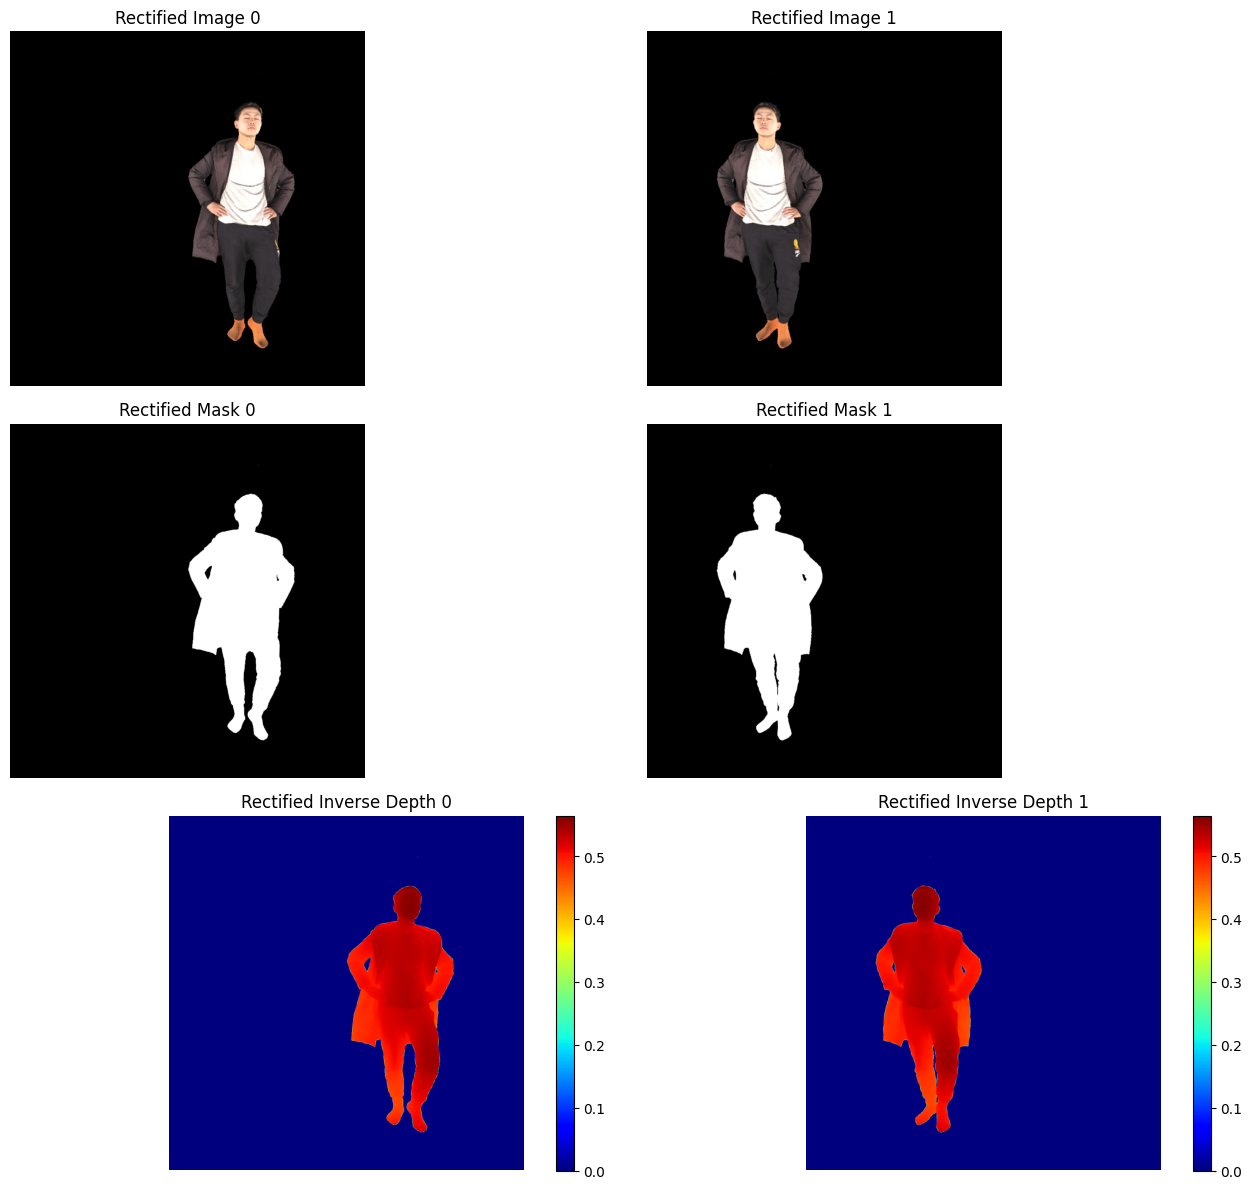


--- Statistics (Masked Area) ---
ID 0:
  Inverse Depth Mean: 0.516026
  Inverse Depth Get Max:  0.564240
  Inverse Depth Get Min:  0.241089
ID 1:
  Inverse Depth Mean: 0.515182
  Inverse Depth Get Max:  0.563965
  Inverse Depth Get Min:  0.238068


In [89]:
# Visualize Rectified Dataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Configuration
rectified_root = r'd:\GitHub\GPS-Gaussian\render_data\rectified_local\train'
scene_name = '0004_000' # Change if needed
ids = [0, 1]

print(f"Visualizing Rectified Data for scene: {scene_name}, IDs: {ids}")

# Helper to read data
def read_image(path):
    if not os.path.exists(path):
        print(f"Error: {path} not found")
        return None
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def read_mask(path):
    if not os.path.exists(path):
        print(f"Error: {path} not found")
        return None
    mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if mask is not None and mask.ndim == 3:
        mask = mask[:, :, 0] # Take first channel if multiple present
    return mask

def read_inv_depth(path):
    if not os.path.exists(path):
        print(f"Error: {path} not found")
        return None
    # Load as uint16 and convert to float (val / 2^15)
    depth = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if depth is not None and depth.ndim == 3:
        depth = depth[:, :, 0]
    return depth.astype(np.float32) / (2**15)

# Load Data
data = {}
for i in ids:
    img_path = os.path.join(rectified_root, 'img', scene_name, f'{i}.jpg')
    mask_path = os.path.join(rectified_root, 'mask', scene_name, f'{i}.png')
    depth_path = os.path.join(rectified_root, 'depth', scene_name, f'{i}.png')
    
    data[i] = {
        'img': read_image(img_path),
        'mask': read_mask(mask_path),
        'inv_depth': read_inv_depth(depth_path)
    }

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Row 1: Images
axes[0, 0].imshow(data[0]['img'])
axes[0, 0].set_title(f'Rectified Image {ids[0]}')
axes[0, 0].axis('off')

axes[0, 1].imshow(data[1]['img'])
axes[0, 1].set_title(f'Rectified Image {ids[1]}')
axes[0, 1].axis('off')

# Row 2: Masks
axes[1, 0].imshow(data[0]['mask'], cmap='gray')
axes[1, 0].set_title(f'Rectified Mask {ids[0]}')
axes[1, 0].axis('off')

axes[1, 1].imshow(data[1]['mask'], cmap='gray')
axes[1, 1].set_title(f'Rectified Mask {ids[1]}')
axes[1, 1].axis('off')

# Row 3: Inverse Depths
inv_d0 = data[0]['inv_depth']
inv_d1 = data[1]['inv_depth']

# Filter for better visualization range (ignore background 0s if possible)
vmin = 0
vmax = max(inv_d0.max(), inv_d1.max())
if vmax == 0: vmax = 1.0 # fallback

im0 = axes[2, 0].imshow(inv_d0, cmap='jet', vmin=vmin, vmax=vmax)
axes[2, 0].set_title(f'Rectified Inverse Depth {ids[0]}')
axes[2, 0].axis('off')
plt.colorbar(im0, ax=axes[2, 0], fraction=0.046, pad=0.04)

im1 = axes[2, 1].imshow(inv_d1, cmap='jet', vmin=vmin, vmax=vmax)
axes[2, 1].set_title(f'Rectified Inverse Depth {ids[1]}')
axes[2, 1].axis('off')
plt.colorbar(im1, ax=axes[2, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Print statistics for verification
print("\n--- Statistics (Masked Area) ---")
for i in ids:
    # Ensure consistency in dimensions
    mask = data[i]['mask']
    inv_depth = data[i]['inv_depth']
    
    if mask.shape != inv_depth.shape:
        print(f"Warning: Mask shape {mask.shape} != Inv Depth shape {inv_depth.shape}")
        # Resize mask to match depth if necessary (though they should match)
        if mask.shape[:2] != inv_depth.shape[:2]:
             mask = cv2.resize(mask, (inv_depth.shape[1], inv_depth.shape[0]), interpolation=cv2.INTER_NEAREST)

    mask_bool = mask > 128
    masked_inv_depth = inv_depth[mask_bool]
    
    print(f"ID {i}:")
    print(f"  Inverse Depth Mean: {masked_inv_depth.mean():.6f}")
    print(f"  Inverse Depth Get Max:  {masked_inv_depth.max():.6f}") # avoided 'max' keyword conflict if any
    print(f"  Inverse Depth Get Min:  {masked_inv_depth.min():.6f}")


Initializing StereoHumanRender...
Loaded checkpoint from pretrained/GPS-GS_stage2_final.pth
Running Inference...


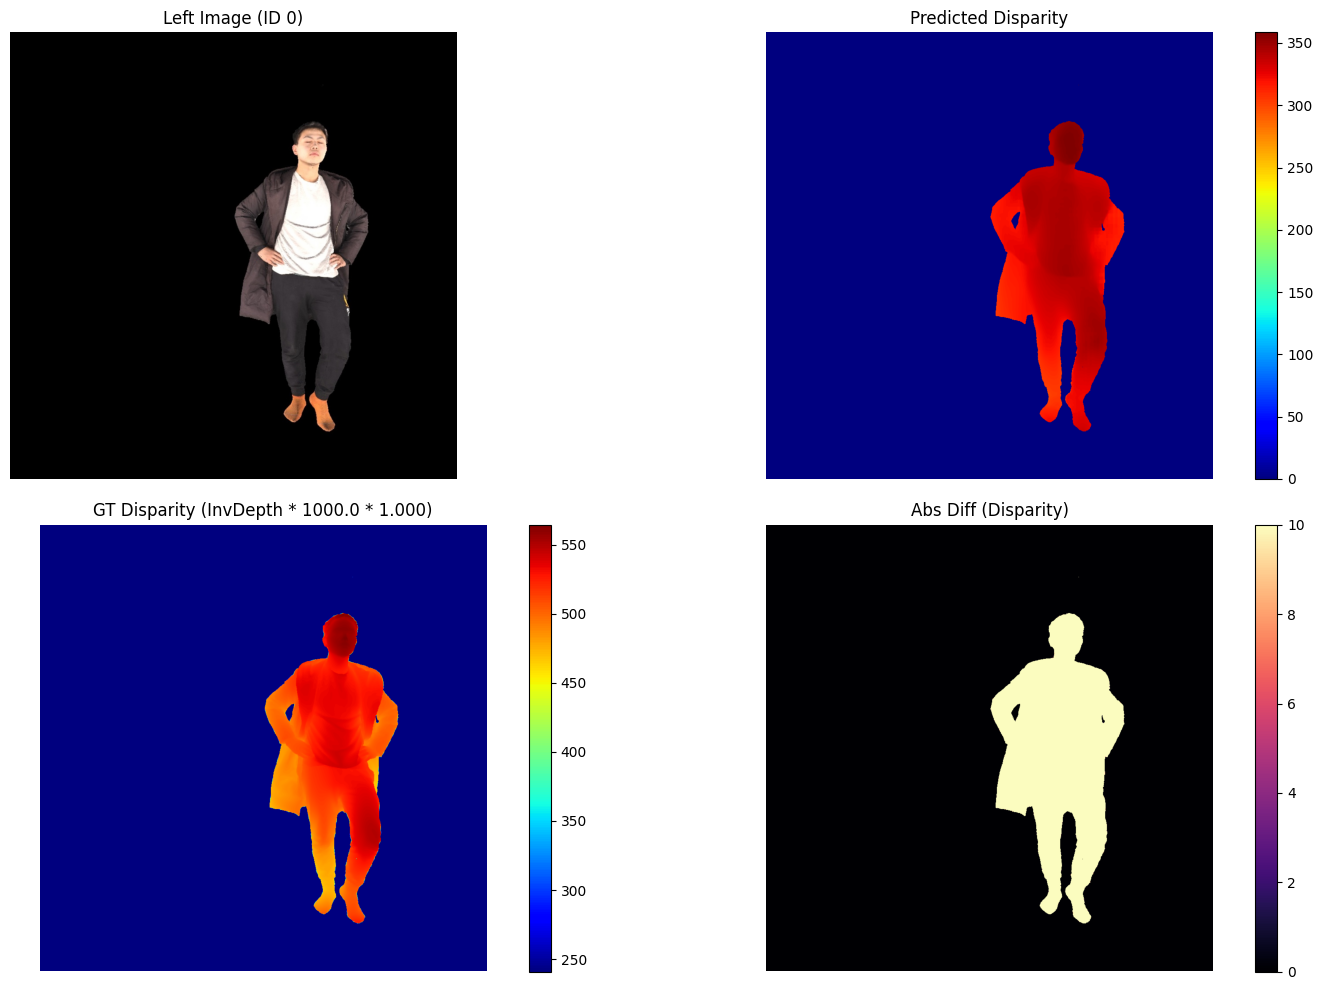


--- Cross-Section Analysis ---


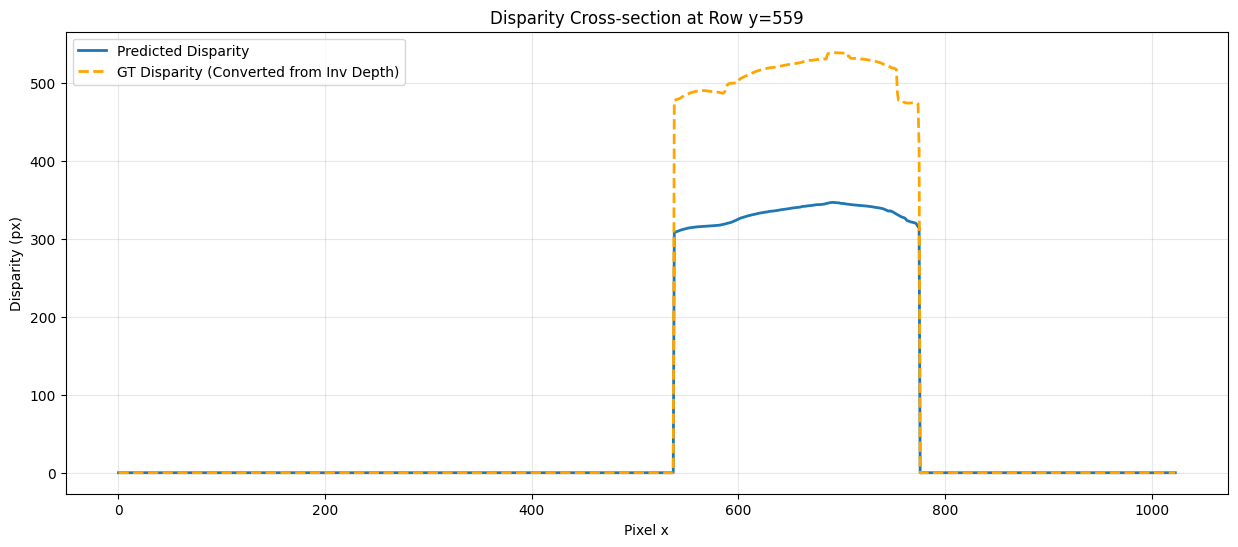

Row 559: Mean Abs Error = 179.4043 px

Global Stats:
MAE (Disparity): 183.7382 px
Mean Pred: 332.5092, Mean GT: 516.0259


In [ ]:
# Run Disparity Prediction (Unimatch) and Compare with GT
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from config.transformer_human_config import ConfigStereoHuman as config
from core.raft_stereo_human import StereoHumanRender

# Configuration (Ensure variables are set)
rectified_root = r'd:\GitHub\GPS-Gaussian\render_data\rectified_local\train'
scene_name = '0004_000'
ids = [0, 1]

# 1. Setup Model
print("Initializing StereoHumanRender...")
cfg = config()
cfg_for_test = os.path.join('./config', 'small_cap.yaml')
cfg.load(cfg_for_test)
cfg = cfg.get_cfg()
cfg.defrost()
cfg.batch_size = 1
cfg.dataset.use_processed_data = False
cfg.restore_ckpt = 'pretrained/GPS-GS_stage2_final.pth'
cfg.unimatch.unimatch_ckpt = 'unimatch/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth'
cfg.freeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
renderer = StereoHumanRender(cfg, phase='test')
renderer.pred_bidir_disp = True 

# 2. Prepare Data
# Load Camera Params for f and Baseline to convert InvDepth -> Disparity
# NOTE: Using 'parm' folder, not 'cam_params'
intr0_path = os.path.join(rectified_root, 'parm', scene_name, f'{ids[0]}_intrinsic.npy')
extr0_path = os.path.join(rectified_root, 'parm', scene_name, f'{ids[0]}_extrinsic.npy')
intr1_path = os.path.join(rectified_root, 'parm', scene_name, f'{ids[1]}_intrinsic.npy')
extr1_path = os.path.join(rectified_root, 'parm', scene_name, f'{ids[1]}_extrinsic.npy')

if os.path.exists(intr0_path):
    intr0 = np.load(intr0_path)
    extr0 = np.load(extr0_path)
    intr1 = np.load(intr1_path)
    extr1 = np.load(extr1_path)
    
    # Handle 3x4 vs 4x4
    if extr0.shape[0] == 3: extr0 = np.vstack([extr0, [0,0,0,1]])
    if extr1.shape[0] == 3: extr1 = np.vstack([extr1, [0,0,0,1]])

    # Calculate Baseline
    pos0 = (-extr0[:3,:3].T @ extr0[:3,3]).flatten()
    pos1 = (-extr1[:3,:3].T @ extr1[:3,3]).flatten()
    baseline = np.linalg.norm(pos0 - pos1)
    
    # Focal length 
    fx = intr0[0,0]
    
    print(f"Loaded Params -> Baseline: {baseline:.5f}, fx: {fx:.5f}")
else:
    print(f"Warning: Camera params not found at {intr0_path}. Using defaults.")
    baseline = 1.0 
    fx = 1000.0

# Prepare Tensors
if ids[0] not in data:
    raise ValueError("Data dict missing. Please re-run the previous visualization cell to load data[0] and data[1].")

img0_tensor = torch.from_numpy(data[ids[0]]['img']).permute(2, 0, 1).float() / 255.0
img1_tensor = torch.from_numpy(data[ids[1]]['img']).permute(2, 0, 1).float() / 255.0

mask0 = data[ids[0]]['mask']
mask1 = data[ids[1]]['mask']
mask0_3ch = np.stack([mask0, mask0, mask0], axis=-1)
mask1_3ch = np.stack([mask1, mask1, mask1], axis=-1)
mask0_tensor = torch.from_numpy(mask0_3ch).permute(2, 0, 1).float() / 255.0
mask1_tensor = torch.from_numpy(mask1_3ch).permute(2, 0, 1).float() / 255.0

data_item = {
    'lmain': { 'img': img0_tensor * 255.0, 'img_ori': img0_tensor, 'mask': mask0_tensor },
    'rmain': { 'img': img1_tensor * 255.0, 'img_ori': img1_tensor, 'mask': mask1_tensor }
}

# 3. Predict Disparity
print("Running Inference...")
with torch.no_grad():
    unimatch_disp = renderer.run_unimatch_inference(data_item)

# 4. Process Results
pred_disp = unimatch_disp[0, 0].cpu().numpy()

# Conversion: GT Disparity = GT InvDepth * fx * baseline
gt_inv_depth = data[ids[0]]['inv_depth']
gt_disp_converted = gt_inv_depth * fx * baseline

# Create valid mask for stats (exclude background and invalid depth)
valid_mask = (gt_inv_depth > 0) & (data[ids[0]]['mask'] > 128)

# Mask the arrays for valid comparison
pred_disp_masked = pred_disp.copy()
pred_disp_masked[~valid_mask] = 0

gt_disp_masked = gt_disp_converted.copy()
gt_disp_masked[~valid_mask] = 0

# 5. Visualization (Heatmaps)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Image
axes[0,0].imshow(data[ids[0]]['img'])
axes[0,0].set_title(f"Left Image (ID {ids[0]})")
axes[0,0].axis('off')

# Prediction
im1 = axes[0,1].imshow(pred_disp_masked, cmap='jet')
axes[0,1].set_title(f"Predicted Disparity")
axes[0,1].axis('off')
plt.colorbar(im1, ax=axes[0,1])

# GT
vmin = min(pred_disp_masked[valid_mask].min(), gt_disp_masked[valid_mask].min())
vmax = max(pred_disp_masked[valid_mask].max(), gt_disp_masked[valid_mask].max())
if vmax <= vmin: vmax = vmin + 1

im2 = axes[1,0].imshow(gt_disp_masked, cmap='jet', vmin=vmin, vmax=vmax)
axes[1,0].set_title(f"GT Disparity (InvDepth * {fx:.1f} * {baseline:.3f})")
axes[1,0].axis('off')
plt.colorbar(im2, ax=axes[1,0])

# Diff
diff = np.abs(pred_disp_masked - gt_disp_masked)
diff[~valid_mask] = 0
im3 = axes[1,1].imshow(diff, cmap='magma', vmax=10)
axes[1,1].set_title(f"Abs Diff (Disparity)")
axes[1,1].axis('off')
plt.colorbar(im3, ax=axes[1,1])

plt.tight_layout()
plt.show()

# 6. Cross-Section Line Plot (Like Cell 9)
print("\n--- Cross-Section Analysis ---")
y_indices, x_indices = np.where(valid_mask)
if len(y_indices) > 0:
    unique_ys = np.unique(y_indices)
    mid_y_idx = len(unique_ys) // 2
    y_loc = unique_ys[mid_y_idx]

    # Extract lines
    pred_line = pred_disp_masked[y_loc, :]
    gt_line = gt_disp_masked[y_loc, :]
    
    plt.figure(figsize=(15, 6))
    plt.plot(pred_line, label='Predicted Disparity', linewidth=2)
    plt.plot(gt_line, label='GT Disparity (Converted from Inv Depth)', linewidth=2, linestyle='--', color='orange')
    plt.title(f'Disparity Cross-section at Row y={y_loc}')
    plt.xlabel('Pixel x')
    plt.ylabel('Disparity (px)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Stats on line
    valid_on_line = valid_mask[y_loc, :]
    if np.any(valid_on_line):
        line_diff = np.abs(pred_line[valid_on_line] - gt_line[valid_on_line])
        print(f"Row {y_loc}: Mean Abs Error = {line_diff.mean():.4f} px")
else:
    print("No valid pixels found for cross-section.")

# Global Stats
masked_diff = diff[valid_mask]
print(f"\nGlobal Stats:")
print(f"MAE (Disparity): {masked_diff.mean():.4f} px")
print(f"Mean Pred: {pred_disp_masked[valid_mask].mean():.4f}, Mean GT: {gt_disp_masked[valid_mask].mean():.4f}")


In [101]:
# DEBUG: Verify Baseline and Parameters Consistency
import numpy as np
import os
import cv2

print("="*80)
print("DEBUG: Baseline & Parameter Consistency Check")
print("="*80)

# 1. Calculate Baseline from ORIGINAL Raw Data (as done in Cell 5/9)
data_root_orig = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train'
view_name = '0004_000'
ids = [0, 1] # 0=Right? 1=Left? Need to check indexing. 
# Usually Cell 9 assumes 0 and 1.

# Load Original Params
intr0_orig = np.load(os.path.join(data_root_orig, 'parm', view_name, f'{ids[0]}_intrinsic.npy'))
extr0_orig = np.load(os.path.join(data_root_orig, 'parm', view_name, f'{ids[0]}_extrinsic.npy'))
intr1_orig = np.load(os.path.join(data_root_orig, 'parm', view_name, f'{ids[1]}_intrinsic.npy'))
extr1_orig = np.load(os.path.join(data_root_orig, 'parm', view_name, f'{ids[1]}_extrinsic.npy'))

# Ensure 4x4
if extr0_orig.shape[0] == 3: extr0_orig = np.vstack([extr0_orig, [0,0,0,1]])
if extr1_orig.shape[0] == 3: extr1_orig = np.vstack([extr1_orig, [0,0,0,1]])

# Calculate Center and Baseline
c0_orig = (-extr0_orig[:3,:3].T @ extr0_orig[:3,3]).flatten()
c1_orig = (-extr1_orig[:3,:3].T @ extr1_orig[:3,3]).flatten()
baseline_orig = np.linalg.norm(c0_orig - c1_orig)

print(f"[ORIGINAL Data]")
print(f"  Extrinsics Shape: {extr0_orig.shape}")
print(f"  Cam0 Center: {c0_orig}")
print(f"  Cam1 Center: {c1_orig}")
print(f"  Baseline:    {baseline_orig:.6f}")


# 2. Calculate Baseline from SAVED Rectified Data (as done in Comparison Cell)
rectified_root = r'd:\GitHub\GPS-Gaussian\render_data\rectified_local\train'
intr0_rect = np.load(os.path.join(rectified_root, 'parm', view_name, f'{ids[0]}_intrinsic.npy'))
extr0_rect = np.load(os.path.join(rectified_root, 'parm', view_name, f'{ids[0]}_extrinsic.npy'))
intr1_rect = np.load(os.path.join(rectified_root, 'parm', view_name, f'{ids[1]}_intrinsic.npy'))
extr1_rect = np.load(os.path.join(rectified_root, 'parm', view_name, f'{ids[1]}_extrinsic.npy'))

# Ensure 4x4
if extr0_rect.shape[0] == 3: extr0_rect = np.vstack([extr0_rect, [0,0,0,1]])
if extr1_rect.shape[0] == 3: extr1_rect = np.vstack([extr1_rect, [0,0,0,1]])

# Calculate Center and Baseline
c0_rect = (-extr0_rect[:3,:3].T @ extr0_rect[:3,3]).flatten()
c1_rect = (-extr1_rect[:3,:3].T @ extr1_rect[:3,3]).flatten()
baseline_rect = np.linalg.norm(c0_rect - c1_rect)

print(f"\n[RECTIFIED SAVED Data]")
print(f"  Extrinsics Shape: {extr0_rect.shape}")
print(f"  Cam0 Center: {c0_rect}")
print(f"  Cam1 Center: {c1_rect}")
print(f"  Baseline:    {baseline_rect:.6f}")

# 3. Compare
diff = abs(baseline_orig - baseline_rect)
print(f"\n[Comparison]")
print(f"  Baseline Difference: {diff:.8f}")

if diff > 1e-4:
    print(">> FAIL: Baselines do not match! The Rectification process changed the camera centers or units.")
    scale_ratio = baseline_orig / baseline_rect
    print(f"  Ratio (Orig/Rect): {scale_ratio:.4f}")
else:
    print(">> PASS: Baselines match.")

# 4. Check Focal Lengths (Scale related)
# In Cell 9, fx_inf = P0_rect_inf[0, 0] derived from on-the-fly rectification
# In Saved, fx = intr0_rect[0, 0]
# We need to run on-the-fly rectification to get 'Cell 9' fx
H, W = 1024, 1024
cams_info = [{'K': intr0_orig, 'width': W, 'height': H}, {'K': intr1_orig, 'width': W, 'height': H}]
world_extrs = [extr0_orig, extr1_orig]
R0, R1, P0, P1, Q = stereo_rectify_central_axis(cams_info, world_extrs, [0, 1])
fx_cell9 = P0[0,0]
fx_saved = intr0_rect[0,0]

print(f"\n[Focal Length]")
print(f"  Cell 9 (Computed): {fx_cell9:.4f}")
print(f"  Saved (Loaded):    {fx_saved:.4f}")
if abs(fx_cell9 - fx_saved) > 1e-3:
    print(">> FAIL: Focal Lengths mismatch!")
else:
     print(">> PASS: Focal Lengths match.")

# 5. Check GT Disparity Scale Factor (Baseline * fx)
scale_cell9 = baseline_orig * fx_cell9
scale_saved = baseline_rect * fx_saved
print(f"\n[Scale Factor (B * fx)]")
print(f"  Cell 9: {scale_cell9:.4f}")
print(f"  Saved:  {scale_saved:.4f}")
if abs(scale_cell9 - scale_saved) > 1e-2:
    print(">> FAIL: Significant Scale Factor mismatch.")
else:
    print(">> PASS: Scale Factors match.")


DEBUG: Baseline & Parameter Consistency Check
[ORIGINAL Data]
  Extrinsics Shape: (4, 4)
  Cam0 Center: [-0.69268075  1.13391313  1.8976793 ]
  Cam1 Center: [0.08625686 1.13391313 2.01830451]
  Baseline:    0.788222

[RECTIFIED SAVED Data]
  Extrinsics Shape: (4, 4)
  Cam0 Center: [-0.69268075  1.13391313  1.8976793 ]
  Cam1 Center: [0.08625686 1.13391313 2.01830451]
  Baseline:    0.788222

[Comparison]
  Baseline Difference: 0.00000000
>> PASS: Baselines match.

[Focal Length]
  Cell 9 (Computed): 819.2000
  Saved (Loaded):    819.2000
>> PASS: Focal Lengths match.

[Scale Factor (B * fx)]
  Cell 9: 645.7116
  Saved:  645.7116
>> PASS: Scale Factors match.


In [93]:
baseline

1.0